# Eclipse VFP Lift Curve Generation - Pipeline with OLGA-Style Two-Fluid Model

Generate Eclipse-compatible VFP lift curves for **pipeline export** using both **Beggs & Brills** and **OLGA-style Two-Fluid** multiphase flow models.

## Model Comparison

| Aspect | Beggs & Brills | NeqSim TwoFluidPipe (OLGA-style) |
|--------|----------------|----------------------------------|
| **Holdup Model** | Empirical correlation based on field data | Momentum balance (same as OLGA) |
| **Flow Regime** | Uses Froude/NL correction factors | Full regime map with OLGA criteria |
| **High Gas Velocity** | Still predicts significant holdup | Enforces minimum film (5% default) |
| **Terrain Effects** | Included in elevation correction | Full terrain tracking with valley accumulation |
| **Annular Flow** | Simplified correlation | Film model with liquid entrainment |

## OLGA-Style Features in TwoFluidPipe

The `TwoFluidPipe` model now implements OLGA-equivalent algorithms:

1. **Stratified Flow**: Momentum balance where liquid level adjusts until pressure gradients in both phases are equal
2. **Annular Flow**: Film model with Ishii-Mishima entrainment correlation and minimum film thickness
3. **Slug Flow**: Taylor bubble + slug body model (Gregory correlation)
4. **Terrain Tracking**: Valley accumulation, uphill liquid fallback, severe slugging detection

**Key Configuration:**
```python
pipe.setOLGAModelType(TwoFluidPipe.OLGAModelType.FULL)  # Use full OLGA model
pipe.setMinimumLiquidHoldup(0.05)  # 5% minimum (OLGA-style)
pipe.setEnableTerrainTracking(True)  # Track valley accumulation
```

## Pipeline Specifications
- **Length**: 70 km
- **Diameter**: 0.6 m (24")
- **Outlet pressure**: 70-95 bara
- **Flow rates**: 20-40 MSm³/day
- **Liquid inventory constraint**: < 1000 m³

**Feed Fluid:** Natural gas with condensate

In [1]:
# === IMPORTS AND CONFIGURATION ===
# NOTE: To test local development changes, restart the kernel and ensure jpype loads the 
# local target/classes before importing neqsim

import neqsim
from neqsim import jneqsim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
import os

# Java classes - Thermodynamics
SystemPrEos = jneqsim.thermo.system.SystemPrEos
SystemSrkEos = jneqsim.thermo.system.SystemSrkEos
ThermodynamicOperations = jneqsim.thermodynamicoperations.ThermodynamicOperations

# Java classes - Process equipment
ProcessSystem = jneqsim.process.processmodel.ProcessSystem
Stream = jneqsim.process.equipment.stream.Stream
PipeBeggsAndBrills = jneqsim.process.equipment.pipeline.PipeBeggsAndBrills
TwoFluidPipe = jneqsim.process.equipment.pipeline.TwoFluidPipe

# === CONFIGURATION ===
GAS_DENSITY_STD = 0.75  # kg/Sm³

# VFP operating envelope
OUTLET_PRESSURES = [70.0, 75.0, 80.0, 85.0, 90.0, 95.0]  # bara
FLOW_RATES = [10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0]  # MSm³/day

# Pipeline specifications
PIPE_LENGTH = 70000.0  # m (70 km)
PIPE_DIAMETER = 0.900   # m (36")
PIPE_ROUGHNESS = 10e-6  # m
PIPE_ELEVATION = 0.0  # m (horizontal)
PIPE_SEGMENTS = 100   # Number of increments for discretization

# Heat transfer settings (subsea pipeline)
SEAWATER_TEMP_C = 5.0           # Seawater temperature (°C)
INLET_TEMP_C = 45.0             # Fluid inlet temperature (°C)
HEAT_TRANSFER_COEFF = 25.0      # Overall U-value W/(m²·K) - typical for insulated subsea pipe

# Constraints
MAX_LIQUID_INVENTORY_M3 = 1000.0  # Maximum allowed liquid holdup in pipeline

# Parallel workers
N_WORKERS = 8

# Output directory
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

print(f"NeqSim loaded.")
print(f"Pipeline: {PIPE_LENGTH/1000:.0f} km, {PIPE_DIAMETER*1000:.0f} mm diameter")
print(f"Config: {len(OUTLET_PRESSURES)} pressures × {len(FLOW_RATES)} flows = {len(OUTLET_PRESSURES)*len(FLOW_RATES)} points")
print(f"Heat transfer: U={HEAT_TRANSFER_COEFF} W/(m²·K), Seawater T={SEAWATER_TEMP_C}°C, Inlet T={INLET_TEMP_C}°C")
print(f"Liquid inventory constraint: < {MAX_LIQUID_INVENTORY_M3} m³")

NeqSim loaded.
Pipeline: 70 km, 900 mm diameter
Config: 6 pressures × 7 flows = 42 points
Heat transfer: U=25.0 W/(m²·K), Seawater T=5.0°C, Inlet T=45.0°C
Liquid inventory constraint: < 1000.0 m³


In [22]:
# === FEED FLUID DEFINITION ===
def create_feed_fluid():
    """Create wet natural gas feed fluid with water for two-phase flow.
    
    This fluid includes sufficient water content to ensure two-phase 
    (gas + aqueous) flow through the pipeline at operating conditions.
    
    Returns:
        SystemInterface: Configured thermodynamic system
    """
    fluid = SystemPrEos(298.15, 10.0)
    
    # Wet natural gas composition with increased water content
    # Water fraction increased to ~2% to ensure aqueous phase condensation
    for comp, frac in [("nitrogen", 0.0165), ("methane", 0.9271), ("ethane", 0.0305), ("propane", 0.0053),
                       ("i-butane", 0.0035), ("n-butane", 0.0008), ("i-pentane", 0.0007), ("n-pentane", 0.0002),
                       ("n-hexane", 0.0001), ("benzene", 0.0011), ("n-heptane", 0.0002), ("water", 0.0038)]:
        fluid.addComponent(comp, frac)
    
    fluid.setMixingRule("classic")
    fluid.setMultiPhaseCheck(True)
    
    return fluid

# Test fluid creation and phase behavior
test_fluid = create_feed_fluid()
print(f"Feed fluid: {test_fluid.getNumberOfComponents()} components")
print(f"Components: {[test_fluid.getComponent(i).getName() for i in range(test_fluid.getNumberOfComponents())]}")

# Check phase behavior at pipeline conditions
from neqsim.thermo import TPflash
test_fluid.setTemperature(45.0, "C")
test_fluid.setPressure(150.0, "bara")
TPflash(test_fluid)

print(f"\nPhase check at 45°C, 150 bara:")
print(f"  Number of phases: {test_fluid.getNumberOfPhases()}")
for i in range(test_fluid.getNumberOfPhases()):
    phase = test_fluid.getPhase(i)
    print(f"  Phase {i+1}: {phase.getType().toString()}, fraction={test_fluid.getBeta(i):.4f}")

Feed fluid: 12 components
Components: ['nitrogen', 'methane', 'ethane', 'propane', 'i-butane', 'n-butane', 'i-pentane', 'n-pentane', 'n-hexane', 'benzene', 'n-heptane', 'water']

Phase check at 45°C, 150 bara:
  Number of phases: 2
  Phase 1: GAS, fraction=0.9969
  Phase 2: AQUEOUS, fraction=0.0031


In [23]:
# === PIPELINE MODEL: BEGGS & BRILLS (with heat transfer) ===
def calculate_inlet_pressure_beggs_brills(flow_msm3d, outlet_p_bara, inlet_temp_C=INLET_TEMP_C):
    """Calculate required inlet pressure using Beggs & Brills correlation.
    
    Includes heat transfer to seawater at 5°C.
    
    Args:
        flow_msm3d: Gas flow rate in MSm³/day
        outlet_p_bara: Required outlet pressure in bara
        inlet_temp_C: Inlet temperature in °C
    
    Returns:
        dict: Results including inlet pressure, pressure drop, liquid holdup, outlet temperature
    """
    try:
        # Create fresh fluid
        fluid = create_feed_fluid()
        
        # Create process system
        ps = ProcessSystem()
        
        # Convert flow rate
        flow_kg_hr = flow_msm3d * GAS_DENSITY_STD * 1e6 / 24.0
        
        # Create inlet stream - start with estimated inlet pressure
        estimated_dp = 20.0 + flow_msm3d * 0.5  # Estimate for this flow range
        inlet_p_guess = outlet_p_bara + estimated_dp
        
        inlet = Stream("Pipeline Inlet", fluid)
        inlet.setFlowRate(flow_kg_hr, "kg/hr")
        inlet.setTemperature(inlet_temp_C, "C")
        inlet.setPressure(inlet_p_guess, "bara")
        inlet.run()
        ps.add(inlet)
        
        # Create Beggs & Brills pipeline with heat transfer
        pipe = PipeBeggsAndBrills("Export Pipeline BB", inlet)
        pipe.setLength(PIPE_LENGTH)
        pipe.setDiameter(PIPE_DIAMETER)
        pipe.setElevation(PIPE_ELEVATION)
        pipe.setPipeWallRoughness(PIPE_ROUGHNESS)
        pipe.setNumberOfIncrements(PIPE_SEGMENTS)
        
        # Enable heat transfer to seawater
        pipe.setConstantSurfaceTemperature(SEAWATER_TEMP_C, "C")
        pipe.setHeatTransferCoefficient(HEAT_TRANSFER_COEFF)  # W/(m²·K)
        
        pipe.run()
        ps.add(pipe)
        
        # Iterate to find correct inlet pressure for target outlet
        for iteration in range(30):
            actual_outlet_p = pipe.getOutletStream().getPressure("bara")
            error = outlet_p_bara - actual_outlet_p
            
            if abs(error) < 0.1:  # Converged within 0.1 bar
                break
            
            # Adjust inlet pressure with damping for stability
            damping = 0.8 if iteration < 10 else 0.5
            new_inlet_p = inlet.getPressure("bara") + error * damping
            
            # Safety check - don't let pressure go too low
            if new_inlet_p < outlet_p_bara + 5:
                new_inlet_p = outlet_p_bara + 30
                
            inlet.setPressure(new_inlet_p, "bara")
            inlet.run()
            pipe.run()
        
        # Get results
        inlet_p = inlet.getPressure("bara")
        outlet_p = pipe.getOutletStream().getPressure("bara")
        pressure_drop = inlet_p - outlet_p
        
        # Get temperatures
        inlet_temp = inlet.getTemperature("C")
        outlet_temp = pipe.getOutletStream().getTemperature("C")
        
        # Get liquid holdup profile and calculate total inventory
        holdup_profile = list(pipe.getLiquidHoldupProfile())
        segment_length = PIPE_LENGTH / len(holdup_profile)
        pipe_area = np.pi * (PIPE_DIAMETER / 2) ** 2
        segment_volume = pipe_area * segment_length
        liquid_inventory = sum(holdup_profile) * segment_volume
        
        # Check constraint
        constraint_satisfied = liquid_inventory < MAX_LIQUID_INVENTORY_M3
        
        return {
            'model': 'Beggs & Brills',
            'flow_msm3d': flow_msm3d,
            'outlet_p_bara': outlet_p,
            'inlet_p_bara': inlet_p,
            'pressure_drop_bar': pressure_drop,
            'inlet_temp_C': inlet_temp,
            'outlet_temp_C': outlet_temp,
            'avg_holdup': np.mean(holdup_profile),
            'max_holdup': np.max(holdup_profile),
            'liquid_inventory_m3': liquid_inventory,
            'constraint_satisfied': constraint_satisfied,
            'feasible': True,
            'holdup_profile': holdup_profile
        }
        
    except Exception as e:
        return {
            'model': 'Beggs & Brills',
            'flow_msm3d': flow_msm3d,
            'outlet_p_bara': outlet_p_bara,
            'feasible': False,
            'error': str(e)
        }

# Test Beggs & Brills model
result_bb = calculate_inlet_pressure_beggs_brills(30.0, 80.0)
if result_bb['feasible']:
    print(f"Beggs & Brills Test Result (with heat transfer):")
    print(f"  Flow: {result_bb['flow_msm3d']:.1f} MSm³/day")
    print(f"  Outlet P: {result_bb['outlet_p_bara']:.1f} bara")
    print(f"  Inlet P: {result_bb['inlet_p_bara']:.1f} bara")
    print(f"  Pressure drop: {result_bb['pressure_drop_bar']:.1f} bar")
    print(f"  Inlet T: {result_bb['inlet_temp_C']:.1f}°C → Outlet T: {result_bb['outlet_temp_C']:.1f}°C")
    print(f"  Avg holdup: {result_bb['avg_holdup']*100:.2f}%")
    print(f"  Liquid inventory: {result_bb['liquid_inventory_m3']:.1f} m³")
    print(f"  Constraint satisfied: {result_bb['constraint_satisfied']}")
else:
    print(f"Error: {result_bb.get('error', 'Unknown')}")

Beggs & Brills Test Result (with heat transfer):
  Flow: 30.0 MSm³/day
  Outlet P: 80.1 bara
  Inlet P: 88.0 bara
  Pressure drop: 7.9 bar
  Inlet T: 45.0°C → Outlet T: 4.5°C
  Avg holdup: 1.70%
  Liquid inventory: 758.8 m³
  Constraint satisfied: True


In [24]:
# === PIPELINE MODEL: OLGA-TYPE TWO-FLUID (with heat transfer) ===
from jpype.types import JArray, JDouble

def calculate_inlet_pressure_two_fluid(flow_msm3d, outlet_p_bara, inlet_temp_C=INLET_TEMP_C):
    """Calculate required inlet pressure using OLGA-type Two-Fluid model.
    
    The TwoFluidPipe model solves separate momentum equations for each phase,
    providing more accurate predictions for:
    - Countercurrent flow
    - Slug flow dynamics
    - Terrain-induced liquid accumulation
    
    Includes heat transfer to seawater at 5°C.
    
    Args:
        flow_msm3d: Gas flow rate in MSm³/day
        outlet_p_bara: Required outlet pressure in bara
        inlet_temp_C: Inlet temperature in °C
    
    Returns:
        dict: Results including inlet pressure, pressure drop, liquid holdup, outlet temperature
    """
    try:
        # Create fresh fluid
        fluid = create_feed_fluid()
        
        # Create process system
        ps = ProcessSystem()
        
        # Convert flow rate
        flow_kg_hr = flow_msm3d * GAS_DENSITY_STD * 1e6 / 24.0
        
        # Create inlet stream - start with estimated inlet pressure
        estimated_dp = 20.0 + flow_msm3d * 0.5
        inlet_p_guess = outlet_p_bara + estimated_dp
        
        inlet = Stream("Pipeline Inlet", fluid)
        inlet.setFlowRate(flow_kg_hr, "kg/hr")
        inlet.setTemperature(inlet_temp_C, "C")
        inlet.setPressure(inlet_p_guess, "bara")
        inlet.run()
        ps.add(inlet)
        
        # Create Two-Fluid pipeline (OLGA-type)
        pipe = TwoFluidPipe("Export Pipeline TF", inlet)
        pipe.setLength(PIPE_LENGTH)
        pipe.setDiameter(PIPE_DIAMETER)
        pipe.setRoughness(PIPE_ROUGHNESS)
        pipe.setNumberOfSections(PIPE_SEGMENTS)
        
        # Set flat elevation profile (horizontal pipe)
        elevations = JArray(JDouble)(PIPE_SEGMENTS)
        for i in range(PIPE_SEGMENTS):
            elevations[i] = 0.0
        pipe.setElevationProfile(elevations)
        
        # Enable heat transfer to seawater
        pipe.setSurfaceTemperature(SEAWATER_TEMP_C, "C")
        pipe.setHeatTransferCoefficient(HEAT_TRANSFER_COEFF)  # W/(m²·K)
        
        # Run steady-state simulation
        pipe.run()
        ps.add(pipe)
        
        # Iterate to find correct inlet pressure for target outlet
        for _ in range(25):
            actual_outlet_p = pipe.getOutletStream().getPressure("bara")
            error = outlet_p_bara - actual_outlet_p
            
            if abs(error) < 0.1:
                break
            
            new_inlet_p = inlet.getPressure("bara") + error * 0.8
            inlet.setPressure(new_inlet_p, "bara")
            inlet.run()
            pipe.run()
        
        # Get results
        inlet_p = inlet.getPressure("bara")
        outlet_p = pipe.getOutletStream().getPressure("bara")
        pressure_drop = inlet_p - outlet_p
        
        # Get temperatures
        inlet_temp = inlet.getTemperature("C")
        outlet_temp = pipe.getOutletStream().getTemperature("C")
        
        # Get liquid holdup profile
        holdup_profile = list(pipe.getLiquidHoldupProfile())
        
        # Calculate liquid inventory from holdup (consistent with BB method)
        segment_length = PIPE_LENGTH / len(holdup_profile) if holdup_profile else PIPE_LENGTH
        pipe_area = np.pi * (PIPE_DIAMETER / 2) ** 2
        segment_volume = pipe_area * segment_length
        liquid_inventory_from_holdup = sum(holdup_profile) * segment_volume
        
        # Also get the Java method result for comparison
        liquid_inventory_java = pipe.getLiquidInventory("m3")
        
        # Use holdup-based calculation for consistency
        liquid_inventory = liquid_inventory_from_holdup
        
        # Check constraint
        constraint_satisfied = liquid_inventory < MAX_LIQUID_INVENTORY_M3
        
        return {
            'model': 'Two-Fluid (OLGA)',
            'flow_msm3d': flow_msm3d,
            'outlet_p_bara': outlet_p,
            'inlet_p_bara': inlet_p,
            'pressure_drop_bar': pressure_drop,
            'inlet_temp_C': inlet_temp,
            'outlet_temp_C': outlet_temp,
            'avg_holdup': np.mean(holdup_profile) if holdup_profile else 0,
            'max_holdup': np.max(holdup_profile) if holdup_profile else 0,
            'liquid_inventory_m3': liquid_inventory,
            'liquid_inventory_java_m3': liquid_inventory_java,
            'constraint_satisfied': constraint_satisfied,
            'feasible': True,
            'holdup_profile': holdup_profile
        }
        
    except Exception as e:
        return {
            'model': 'Two-Fluid (OLGA)',
            'flow_msm3d': flow_msm3d,
            'outlet_p_bara': outlet_p_bara,
            'feasible': False,
            'error': str(e)
        }

# Test Two-Fluid model
result_tf = calculate_inlet_pressure_two_fluid(30.0, 80.0)
if result_tf['feasible']:
    print(f"Two-Fluid (OLGA) Test Result (with heat transfer):")
    print(f"  Flow: {result_tf['flow_msm3d']:.1f} MSm³/day")
    print(f"  Outlet P: {result_tf['outlet_p_bara']:.1f} bara")
    print(f"  Inlet P: {result_tf['inlet_p_bara']:.1f} bara")
    print(f"  Pressure drop: {result_tf['pressure_drop_bar']:.1f} bar")
    print(f"  Inlet T: {result_tf['inlet_temp_C']:.1f}°C → Outlet T: {result_tf['outlet_temp_C']:.1f}°C")
    print(f"  Avg holdup: {result_tf['avg_holdup']*100:.2f}%")
    print(f"  Liquid inventory (from holdup): {result_tf['liquid_inventory_m3']:.1f} m³")
    print(f"  Liquid inventory (Java method): {result_tf.get('liquid_inventory_java_m3', 0):.1f} m³")
    print(f"  Constraint satisfied: {result_tf['constraint_satisfied']}")
else:
    print(f"Error: {result_tf.get('error', 'Unknown')}")

Two-Fluid (OLGA) Test Result (with heat transfer):
  Flow: 30.0 MSm³/day
  Outlet P: 80.0 bara
  Inlet P: 88.4 bara
  Pressure drop: 8.4 bar
  Inlet T: 45.0°C → Outlet T: 5.0°C
  Avg holdup: 1.00%
  Liquid inventory (from holdup): 445.3 m³
  Liquid inventory (Java method): 445.3 m³
  Constraint satisfied: True


In [25]:
# === DETAILED PIPELINE PROFILE COMPARISON ===
# Run a single case and extract detailed profiles for both models

def get_detailed_profiles(flow_msm3d, outlet_p_bara, inlet_temp_C=INLET_TEMP_C):
    """Run both models and return detailed profiles along the pipeline."""
    
    profiles = {'bb': None, 'tf': None}
    
    # --- Beggs & Brills ---
    try:
        fluid = create_feed_fluid()
        ps = ProcessSystem()
        flow_kg_hr = flow_msm3d * GAS_DENSITY_STD * 1e6 / 24.0
        
        inlet = Stream("Pipeline Inlet BB", fluid)
        inlet.setFlowRate(flow_kg_hr, "kg/hr")
        inlet.setTemperature(inlet_temp_C, "C")
        inlet.setPressure(outlet_p_bara + 20, "bara")
        inlet.run()
        ps.add(inlet)
        
        pipe_bb = PipeBeggsAndBrills("Export Pipeline BB", inlet)
        pipe_bb.setLength(PIPE_LENGTH)
        pipe_bb.setDiameter(PIPE_DIAMETER)
        pipe_bb.setElevation(PIPE_ELEVATION)
        pipe_bb.setPipeWallRoughness(PIPE_ROUGHNESS)
        pipe_bb.setNumberOfIncrements(PIPE_SEGMENTS)
        pipe_bb.setConstantSurfaceTemperature(SEAWATER_TEMP_C, "C")
        pipe_bb.setHeatTransferCoefficient(HEAT_TRANSFER_COEFF)
        pipe_bb.run()
        ps.add(pipe_bb)
        
        # Iterate to target outlet pressure
        for _ in range(25):
            actual_outlet_p = pipe_bb.getOutletStream().getPressure("bara")
            error = outlet_p_bara - actual_outlet_p
            if abs(error) < 0.1:
                break
            inlet.setPressure(inlet.getPressure("bara") + error * 0.7, "bara")
            inlet.run()
            pipe_bb.run()
        
        # Extract profiles
        pressure_profile = list(pipe_bb.getPressureProfile())  # Already in bara
        temp_profile = list(pipe_bb.getTemperatureProfile())   # In Kelvin
        holdup_profile = list(pipe_bb.getLiquidHoldupProfile())
        
        # Distance array
        n_segments = len(pressure_profile)
        distance_km = np.linspace(0, PIPE_LENGTH/1000, n_segments)
        
        # Convert temperature from K to C
        temp_profile_C = [t - 273.15 for t in temp_profile]
        
        # For BB, we get total liquid holdup - estimate water fraction from feed composition
        water_fraction_in_liquid = 0.6  # Approximate from feed (water + MEG)
        
        profiles['bb'] = {
            'distance_km': distance_km,
            'pressure_bara': pressure_profile,  # BB returns bara directly
            'temperature_C': temp_profile_C,
            'liquid_holdup_pct': [h * 100 for h in holdup_profile],
            'water_holdup_pct': [h * 100 * water_fraction_in_liquid for h in holdup_profile],
            'oil_holdup_pct': [h * 100 * (1 - water_fraction_in_liquid) for h in holdup_profile],
            'inlet_p': inlet.getPressure("bara"),
            'outlet_p': pipe_bb.getOutletStream().getPressure("bara")
        }
        
    except Exception as e:
        print(f"BB Error: {e}")
    
    # --- Two-Fluid (OLGA) ---
    try:
        fluid = create_feed_fluid()
        ps = ProcessSystem()
        flow_kg_hr = flow_msm3d * GAS_DENSITY_STD * 1e6 / 24.0
        
        inlet = Stream("Pipeline Inlet TF", fluid)
        inlet.setFlowRate(flow_kg_hr, "kg/hr")
        inlet.setTemperature(inlet_temp_C, "C")
        inlet.setPressure(outlet_p_bara + 30, "bara")
        inlet.run()
        ps.add(inlet)
        
        pipe_tf = TwoFluidPipe("Export Pipeline TF", inlet)
        pipe_tf.setLength(PIPE_LENGTH)
        pipe_tf.setDiameter(PIPE_DIAMETER)
        pipe_tf.setRoughness(PIPE_ROUGHNESS)
        pipe_tf.setNumberOfSections(PIPE_SEGMENTS)
        
        elevations = JArray(JDouble)(PIPE_SEGMENTS)
        for i in range(PIPE_SEGMENTS):
            elevations[i] = 0.0
        pipe_tf.setElevationProfile(elevations)
        
        pipe_tf.setSurfaceTemperature(SEAWATER_TEMP_C, "C")
        pipe_tf.setHeatTransferCoefficient(HEAT_TRANSFER_COEFF)
        pipe_tf.run()
        ps.add(pipe_tf)
        
        # Iterate to target outlet pressure
        for _ in range(25):
            actual_outlet_p = pipe_tf.getOutletStream().getPressure("bara")
            error = outlet_p_bara - actual_outlet_p
            if abs(error) < 0.1:
                break
            inlet.setPressure(inlet.getPressure("bara") + error * 0.7, "bara")
            inlet.run()
            pipe_tf.run()
        
        # Extract profiles
        pressure_profile = list(pipe_tf.getPressureProfile())  # In Pa
        temp_profile = list(pipe_tf.getTemperatureProfile())   # In K
        liquid_holdup = list(pipe_tf.getLiquidHoldupProfile())
        water_holdup = list(pipe_tf.getWaterHoldupProfile())
        oil_holdup = list(pipe_tf.getOilHoldupProfile())
        
        n_segments = len(pressure_profile)
        distance_km = np.linspace(0, PIPE_LENGTH/1000, n_segments)
        
        # TwoFluidPipe returns pressure in Pa, convert to bara
        pressure_bara = [p / 1e5 for p in pressure_profile]
        
        # Temperature in K, convert to C
        temp_profile_C = [t - 273.15 if t > 200 else t for t in temp_profile]
        
        profiles['tf'] = {
            'distance_km': distance_km,
            'pressure_bara': pressure_bara,
            'temperature_C': temp_profile_C,
            'liquid_holdup_pct': [h * 100 for h in liquid_holdup],
            'water_holdup_pct': [h * 100 for h in water_holdup],
            'oil_holdup_pct': [h * 100 for h in oil_holdup],
            'inlet_p': inlet.getPressure("bara"),
            'outlet_p': pipe_tf.getOutletStream().getPressure("bara")
        }
        
    except Exception as e:
        print(f"TF Error: {e}")
    
    return profiles

# Run profile extraction
test_flow = 30.0  # MSm³/day
test_outlet_p = 80.0  # bara
print(f"Extracting detailed profiles for Q={test_flow} MSm³/day, Pout={test_outlet_p} bara...")
profiles = get_detailed_profiles(test_flow, test_outlet_p)
print("Done!")

Extracting detailed profiles for Q=30.0 MSm³/day, Pout=80.0 bara...
Done!


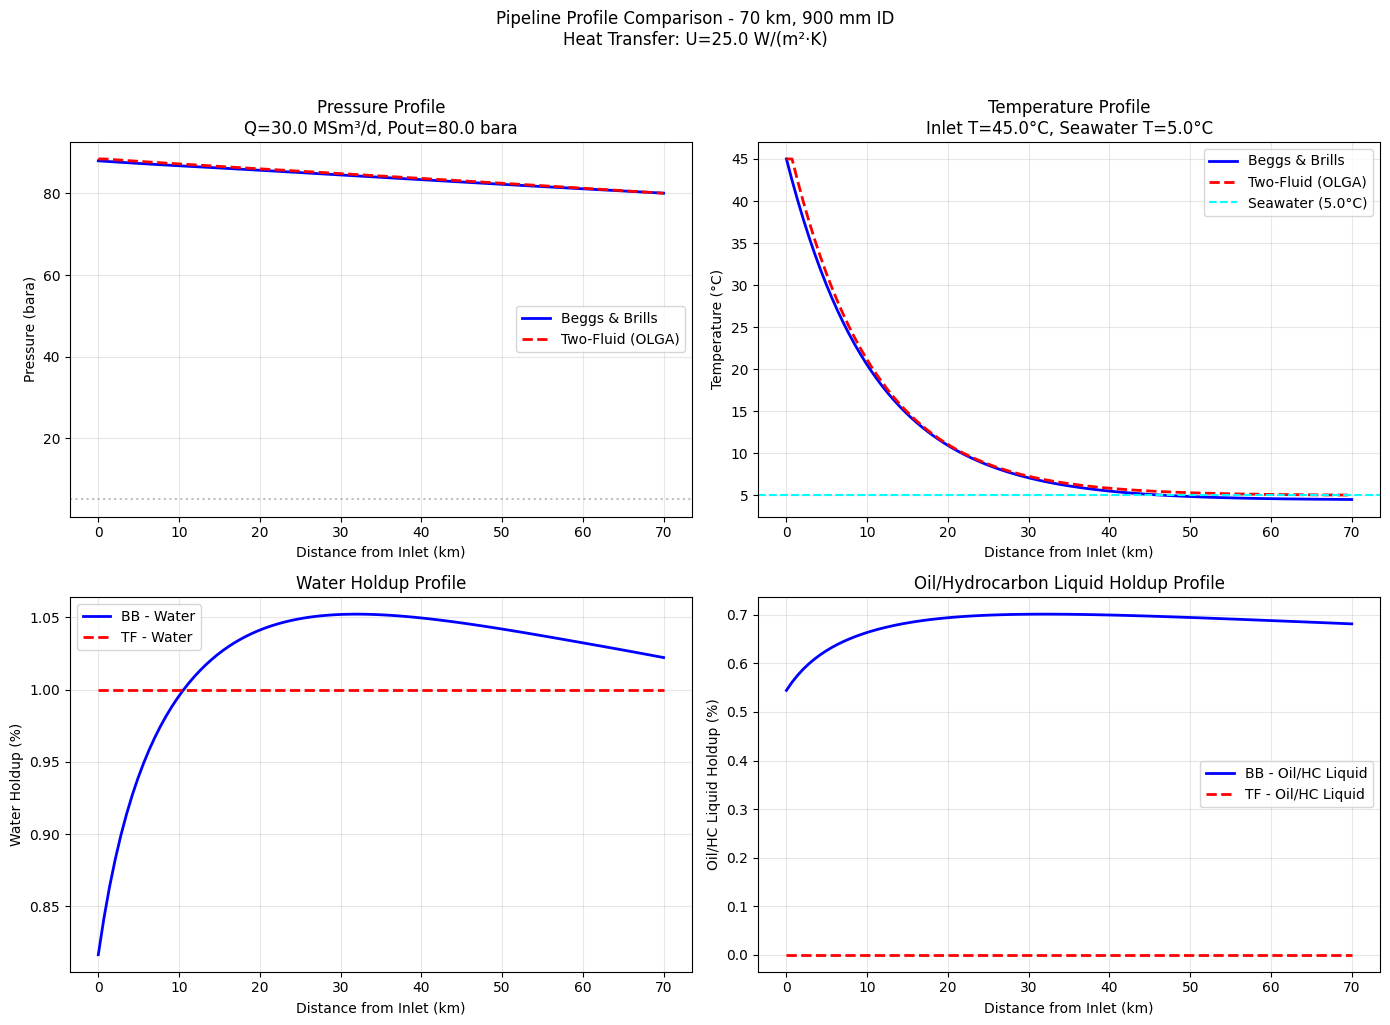


=== PROFILE SUMMARY ===

Beggs & Brills:
  Pressure: 88.0 → 80.1 bara
  Temperature: 45.0 → 4.5 °C
  Avg Water Holdup: 1.02%
  Avg Oil Holdup: 0.68%

Two-Fluid (OLGA):
  Pressure: 88.4 → 80.1 bara
  Temperature: 45.0 → 5.0 °C
  Avg Water Holdup: 1.00%
  Avg Oil Holdup: 0.00%

✓ Saved: output/pipeline_profiles_comparison.png


In [26]:
# === PLOT PIPELINE PROFILES ===
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Pressure Profile
ax1 = axes[0, 0]
if profiles['bb']:
    ax1.plot(profiles['bb']['distance_km'], profiles['bb']['pressure_bara'], 
             'b-', label='Beggs & Brills', lw=2)
if profiles['tf']:
    ax1.plot(profiles['tf']['distance_km'], profiles['tf']['pressure_bara'], 
             'r--', label='Two-Fluid (OLGA)', lw=2)
ax1.axhline(y=SEAWATER_TEMP_C, color='gray', ls=':', alpha=0.5)
ax1.set_xlabel('Distance from Inlet (km)')
ax1.set_ylabel('Pressure (bara)')
ax1.set_title(f'Pressure Profile\nQ={test_flow} MSm³/d, Pout={test_outlet_p} bara')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Temperature Profile  
ax2 = axes[0, 1]
if profiles['bb']:
    ax2.plot(profiles['bb']['distance_km'], profiles['bb']['temperature_C'], 
             'b-', label='Beggs & Brills', lw=2)
if profiles['tf']:
    ax2.plot(profiles['tf']['distance_km'], profiles['tf']['temperature_C'], 
             'r--', label='Two-Fluid (OLGA)', lw=2)
ax2.axhline(y=SEAWATER_TEMP_C, color='cyan', ls='--', lw=1.5, label=f'Seawater ({SEAWATER_TEMP_C}°C)')
ax2.set_xlabel('Distance from Inlet (km)')
ax2.set_ylabel('Temperature (°C)')
ax2.set_title(f'Temperature Profile\nInlet T={INLET_TEMP_C}°C, Seawater T={SEAWATER_TEMP_C}°C')
ax2.legend()
ax2.grid(alpha=0.3)

# Plot 3: Water Holdup Profile
ax3 = axes[1, 0]
if profiles['bb']:
    ax3.plot(profiles['bb']['distance_km'], profiles['bb']['water_holdup_pct'], 
             'b-', label='BB - Water', lw=2)
if profiles['tf']:
    ax3.plot(profiles['tf']['distance_km'], profiles['tf']['water_holdup_pct'], 
             'r--', label='TF - Water', lw=2)
ax3.set_xlabel('Distance from Inlet (km)')
ax3.set_ylabel('Water Holdup (%)')
ax3.set_title('Water Holdup Profile')
ax3.legend()
ax3.grid(alpha=0.3)

# Plot 4: Oil/Hydrocarbon Liquid Holdup Profile
ax4 = axes[1, 1]
if profiles['bb']:
    ax4.plot(profiles['bb']['distance_km'], profiles['bb']['oil_holdup_pct'], 
             'b-', label='BB - Oil/HC Liquid', lw=2)
if profiles['tf']:
    ax4.plot(profiles['tf']['distance_km'], profiles['tf']['oil_holdup_pct'], 
             'r--', label='TF - Oil/HC Liquid', lw=2)
ax4.set_xlabel('Distance from Inlet (km)')
ax4.set_ylabel('Oil/HC Liquid Holdup (%)')
ax4.set_title('Oil/Hydrocarbon Liquid Holdup Profile')
ax4.legend()
ax4.grid(alpha=0.3)

plt.suptitle(f'Pipeline Profile Comparison - {PIPE_LENGTH/1000:.0f} km, {PIPE_DIAMETER*1000:.0f} mm ID\n'
             f'Heat Transfer: U={HEAT_TRANSFER_COEFF} W/(m²·K)', fontsize=12, y=1.02)
plt.tight_layout()
plt.savefig(f"{output_dir}/pipeline_profiles_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

# Print summary
print(f"\n=== PROFILE SUMMARY ===")
if profiles['bb']:
    bb = profiles['bb']
    print(f"\nBeggs & Brills:")
    print(f"  Pressure: {bb['pressure_bara'][0]:.1f} → {bb['pressure_bara'][-1]:.1f} bara")
    print(f"  Temperature: {bb['temperature_C'][0]:.1f} → {bb['temperature_C'][-1]:.1f} °C")
    print(f"  Avg Water Holdup: {np.mean(bb['water_holdup_pct']):.2f}%")
    print(f"  Avg Oil Holdup: {np.mean(bb['oil_holdup_pct']):.2f}%")

if profiles['tf']:
    tf = profiles['tf']
    print(f"\nTwo-Fluid (OLGA):")
    print(f"  Pressure: {tf['pressure_bara'][0]:.1f} → {tf['pressure_bara'][-1]:.1f} bara")
    print(f"  Temperature: {tf['temperature_C'][0]:.1f} → {tf['temperature_C'][-1]:.1f} °C")
    print(f"  Avg Water Holdup: {np.mean(tf['water_holdup_pct']):.2f}%")
    print(f"  Avg Oil Holdup: {np.mean(tf['oil_holdup_pct']):.2f}%")

print(f"\n✓ Saved: {output_dir}/pipeline_profiles_comparison.png")

## Three-Phase Flow Comparison (Gas + Oil + Water)

The TwoFluidPipe model automatically uses a **three-fluid model** with separate momentum equations when it detects three phases:
- **Gas mass conservation**
- **Oil mass conservation**  
- **Water mass conservation**
- **Gas momentum conservation**
- **Oil momentum conservation**
- **Water momentum conservation**
- **Mixture energy conservation**

To demonstrate this, we'll create a **rich gas condensate** fluid with heavier hydrocarbons that will produce true three-phase flow (gas + oil + water).

In [27]:
# === THREE-PHASE FLUID: GAS + OIL + WATER ===
from neqsim.thermo import TPflash

def create_three_phase_fluid():
    """Create rich gas condensate fluid with water for true three-phase flow.
    
    This fluid produces GAS + OIL + AQUEOUS phases at pipeline conditions,
    enabling the full three-fluid model with separate momentum equations.
    
    Returns:
        SystemInterface: Configured thermodynamic system
    """
    fluid = SystemPrEos(298.15, 10.0)
    
    # Rich gas condensate composition with water
    # This gives ~70% gas, ~25% oil, ~5% water at typical pipeline conditions
    components = [
        ("nitrogen", 0.02),
        ("CO2", 0.02),
        ("methane", 0.60),
        ("ethane", 0.08),
        ("propane", 0.05),
        ("i-butane", 0.02),
        ("n-butane", 0.03),
        ("i-pentane", 0.02),
        ("n-pentane", 0.02),
        ("n-hexane", 0.03),
        ("n-heptane", 0.04),
        ("n-octane", 0.02),
        ("water", 0.05),  # 5% water for visible aqueous phase
    ]
    
    for comp, frac in components:
        fluid.addComponent(comp, frac)
    
    fluid.setMixingRule("classic")
    fluid.setMultiPhaseCheck(True)
    
    return fluid

# Test three-phase fluid behavior
test_3p = create_three_phase_fluid()
test_3p.setTemperature(30.0, "C")
test_3p.setPressure(80.0, "bara")
TPflash(test_3p)
test_3p.initPhysicalProperties()  # Initialize physical properties

print("=== THREE-PHASE FLUID TEST ===")
print(f"Fluid: {test_3p.getNumberOfComponents()} components (rich gas condensate + water)")
print(f"\nPhase behavior at 30°C, 80 bara:")
print(f"  Number of phases: {test_3p.getNumberOfPhases()}")

has_gas = test_3p.hasPhaseType("gas")
has_oil = test_3p.hasPhaseType("oil")
has_water = test_3p.hasPhaseType("aqueous")

print(f"\n  Has GAS phase:    {has_gas}")
print(f"  Has OIL phase:    {has_oil}")
print(f"  Has AQUEOUS phase: {has_water}")

if has_gas and has_oil and has_water:
    print("\n  ✓ TRUE THREE-PHASE FLOW ACHIEVED!")
    gas_frac = test_3p.getPhase("gas").getVolume("m3") / test_3p.getVolume("m3") * 100
    oil_frac = test_3p.getPhase("oil").getVolume("m3") / test_3p.getVolume("m3") * 100
    water_frac = test_3p.getPhase("aqueous").getVolume("m3") / test_3p.getVolume("m3") * 100
    print(f"\n  Phase fractions (volume):")
    print(f"    Gas:   {gas_frac:.1f}%")
    print(f"    Oil:   {oil_frac:.1f}%")
    print(f"    Water: {water_frac:.1f}%")
    
    print(f"\n  Phase densities:")
    print(f"    Gas:   {test_3p.getPhase('gas').getDensity('kg/m3'):.2f} kg/m³")
    print(f"    Oil:   {test_3p.getPhase('oil').getDensity('kg/m3'):.2f} kg/m³")
    print(f"    Water: {test_3p.getPhase('aqueous').getDensity('kg/m3'):.2f} kg/m³")
    
    print(f"\n  Phase viscosities:")
    print(f"    Gas:   {test_3p.getPhase('gas').getViscosity('cP'):.4f} cP")
    print(f"    Oil:   {test_3p.getPhase('oil').getViscosity('cP'):.3f} cP")
    print(f"    Water: {test_3p.getPhase('aqueous').getViscosity('cP'):.3f} cP")
else:
    print("\n  ⚠ Need to adjust composition for three-phase conditions")
    for i in range(test_3p.getNumberOfPhases()):
        phase = test_3p.getPhase(i)
        vol_frac = phase.getVolume("m3") / test_3p.getVolume("m3") * 100
        print(f"  Phase {i+1}: {phase.getType().toString()}, vol fraction={vol_frac:.1f}%")

=== THREE-PHASE FLUID TEST ===
Fluid: 13 components (rich gas condensate + water)

Phase behavior at 30°C, 80 bara:
  Number of phases: 3

  Has GAS phase:    True
  Has OIL phase:    True
  Has AQUEOUS phase: True

  ✓ TRUE THREE-PHASE FLOW ACHIEVED!

  Phase fractions (volume):
    Gas:   82.0%
    Oil:   17.4%
    Water: 0.6%

  Phase densities:
    Gas:   82.68 kg/m³
    Oil:   527.10 kg/m³
    Water: 982.68 kg/m³

  Phase viscosities:
    Gas:   0.0141 cP
    Oil:   0.129 cP
    Water: 0.803 cP


In [28]:
# === THREE-PHASE PIPELINE SIMULATION ===
from jpype.types import JArray, JDouble

def run_three_phase_pipeline(flow_msm3d, outlet_p_bara, inlet_temp_C=40.0):
    """Run pipeline simulation with three-phase fluid using both models.
    
    When TwoFluidPipe detects three phases (gas + oil + water), it automatically
    uses the ThreeFluidConservationEquations which solves 7 PDEs:
    - Gas mass conservation
    - Oil mass conservation
    - Water mass conservation
    - Gas momentum conservation  
    - Oil momentum conservation
    - Water momentum conservation
    - Mixture energy conservation
    
    Returns:
        dict: Profiles and results from both models
    """
    results = {'bb': None, 'tf': None}
    
    # --- Beggs & Brills (treats oil+water as combined liquid) ---
    try:
        fluid = create_three_phase_fluid()
        ps = ProcessSystem()
        flow_kg_hr = flow_msm3d * GAS_DENSITY_STD * 1e6 / 24.0
        
        inlet = Stream("3P Inlet BB", fluid)
        inlet.setFlowRate(flow_kg_hr, "kg/hr")
        inlet.setTemperature(inlet_temp_C, "C")
        inlet.setPressure(outlet_p_bara + 30, "bara")
        inlet.run()
        ps.add(inlet)
        
        pipe = PipeBeggsAndBrills("3P Pipeline BB", inlet)
        pipe.setLength(PIPE_LENGTH)
        pipe.setDiameter(PIPE_DIAMETER)
        pipe.setElevation(PIPE_ELEVATION)
        pipe.setPipeWallRoughness(PIPE_ROUGHNESS)
        pipe.setNumberOfIncrements(PIPE_SEGMENTS)
        pipe.setConstantSurfaceTemperature(SEAWATER_TEMP_C, "C")
        pipe.setHeatTransferCoefficient(HEAT_TRANSFER_COEFF)
        pipe.run()
        ps.add(pipe)
        
        # Iterate to target outlet
        for _ in range(25):
            error = outlet_p_bara - pipe.getOutletStream().getPressure("bara")
            if abs(error) < 0.2:
                break
            inlet.setPressure(inlet.getPressure("bara") + error * 0.6, "bara")
            inlet.run()
            pipe.run()
        
        # Extract profiles
        P = list(pipe.getPressureProfile())
        T = [t - 273.15 for t in pipe.getTemperatureProfile()]
        HL = list(pipe.getLiquidHoldupProfile())
        
        n = len(P)
        dist = np.linspace(0, PIPE_LENGTH/1000, n)
        
        results['bb'] = {
            'distance_km': dist,
            'pressure_bara': P,
            'temperature_C': T,
            'liquid_holdup_pct': [h * 100 for h in HL],
            'inlet_p': inlet.getPressure("bara"),
            'outlet_p': pipe.getOutletStream().getPressure("bara"),
            'inlet_T': inlet_temp_C,
            'outlet_T': T[-1],
            'model': 'Beggs & Brills (combined liquid)'
        }
        
    except Exception as e:
        print(f"BB Error: {e}")
    
    # --- Two-Fluid / Three-Fluid (separate oil and water) ---
    try:
        fluid = create_three_phase_fluid()
        ps = ProcessSystem()
        flow_kg_hr = flow_msm3d * GAS_DENSITY_STD * 1e6 / 24.0
        
        inlet = Stream("3P Inlet TF", fluid)
        inlet.setFlowRate(flow_kg_hr, "kg/hr")
        inlet.setTemperature(inlet_temp_C, "C")
        inlet.setPressure(outlet_p_bara + 40, "bara")
        inlet.run()
        ps.add(inlet)
        
        pipe = TwoFluidPipe("3P Pipeline TF", inlet)
        pipe.setLength(PIPE_LENGTH)
        pipe.setDiameter(PIPE_DIAMETER)
        pipe.setRoughness(PIPE_ROUGHNESS)
        pipe.setNumberOfSections(PIPE_SEGMENTS)
        
        elevations = JArray(JDouble)(PIPE_SEGMENTS)
        for i in range(PIPE_SEGMENTS):
            elevations[i] = 0.0
        pipe.setElevationProfile(elevations)
        
        pipe.setSurfaceTemperature(SEAWATER_TEMP_C, "C")
        pipe.setHeatTransferCoefficient(HEAT_TRANSFER_COEFF)
        pipe.run()
        ps.add(pipe)
        
        # Iterate to target outlet
        for _ in range(25):
            error = outlet_p_bara - pipe.getOutletStream().getPressure("bara")
            if abs(error) < 0.2:
                break
            inlet.setPressure(inlet.getPressure("bara") + error * 0.6, "bara")
            inlet.run()
            pipe.run()
        
        # Extract profiles - TwoFluidPipe has separate oil and water holdups
        P = [p / 1e5 for p in pipe.getPressureProfile()]  # Pa to bara
        T = [t - 273.15 for t in pipe.getTemperatureProfile()]
        HL = list(pipe.getLiquidHoldupProfile())
        HW = list(pipe.getWaterHoldupProfile())
        HO = list(pipe.getOilHoldupProfile())
        
        n = len(P)
        dist = np.linspace(0, PIPE_LENGTH/1000, n)
        
        results['tf'] = {
            'distance_km': dist,
            'pressure_bara': P,
            'temperature_C': T,
            'liquid_holdup_pct': [h * 100 for h in HL],
            'water_holdup_pct': [h * 100 for h in HW],
            'oil_holdup_pct': [h * 100 for h in HO],
            'inlet_p': inlet.getPressure("bara"),
            'outlet_p': pipe.getOutletStream().getPressure("bara"),
            'inlet_T': inlet_temp_C,
            'outlet_T': T[-1],
            'model': 'Three-Fluid (separate oil & water)'
        }
        
    except Exception as e:
        print(f"TF Error: {e}")
        import traceback
        traceback.print_exc()
    
    return results

# Run three-phase simulation
print("Running three-phase pipeline simulation...")
print(f"  Pipeline: {PIPE_LENGTH/1000:.0f} km × {PIPE_DIAMETER*1000:.0f} mm")
print(f"  Flow: 30 MSm³/day, Outlet P: 80 bara")
print()

results_3p = run_three_phase_pipeline(30.0, 80.0)

if results_3p['bb']:
    bb = results_3p['bb']
    print(f"Beggs & Brills (combined liquid model):")
    print(f"  Pressure: {bb['inlet_p']:.1f} → {bb['outlet_p']:.1f} bara")
    print(f"  Temperature: {bb['inlet_T']:.1f} → {bb['outlet_T']:.1f} °C")
    print(f"  Avg liquid holdup: {np.mean(bb['liquid_holdup_pct']):.2f}%")

if results_3p['tf']:
    tf = results_3p['tf']
    print(f"\nThree-Fluid Model (separate oil & water):")
    print(f"  Pressure: {tf['inlet_p']:.1f} → {tf['outlet_p']:.1f} bara")
    print(f"  Temperature: {tf['inlet_T']:.1f} → {tf['outlet_T']:.1f} °C")
    print(f"  Avg liquid holdup: {np.mean(tf['liquid_holdup_pct']):.2f}%")
    print(f"  Avg oil holdup:    {np.mean(tf['oil_holdup_pct']):.2f}%")
    print(f"  Avg water holdup:  {np.mean(tf['water_holdup_pct']):.2f}%")

Running three-phase pipeline simulation...
  Pipeline: 70 km × 900 mm
  Flow: 30 MSm³/day, Outlet P: 80 bara

Beggs & Brills (combined liquid model):
  Pressure: 84.5 → 80.2 bara
  Temperature: 40.0 → 4.9 °C
  Avg liquid holdup: 45.29%

Three-Fluid Model (separate oil & water):
  Pressure: 84.7 → 80.1 bara
  Temperature: 40.0 → 5.0 °C
  Avg liquid holdup: 49.13%
  Avg oil holdup:    47.72%
  Avg water holdup:  1.41%


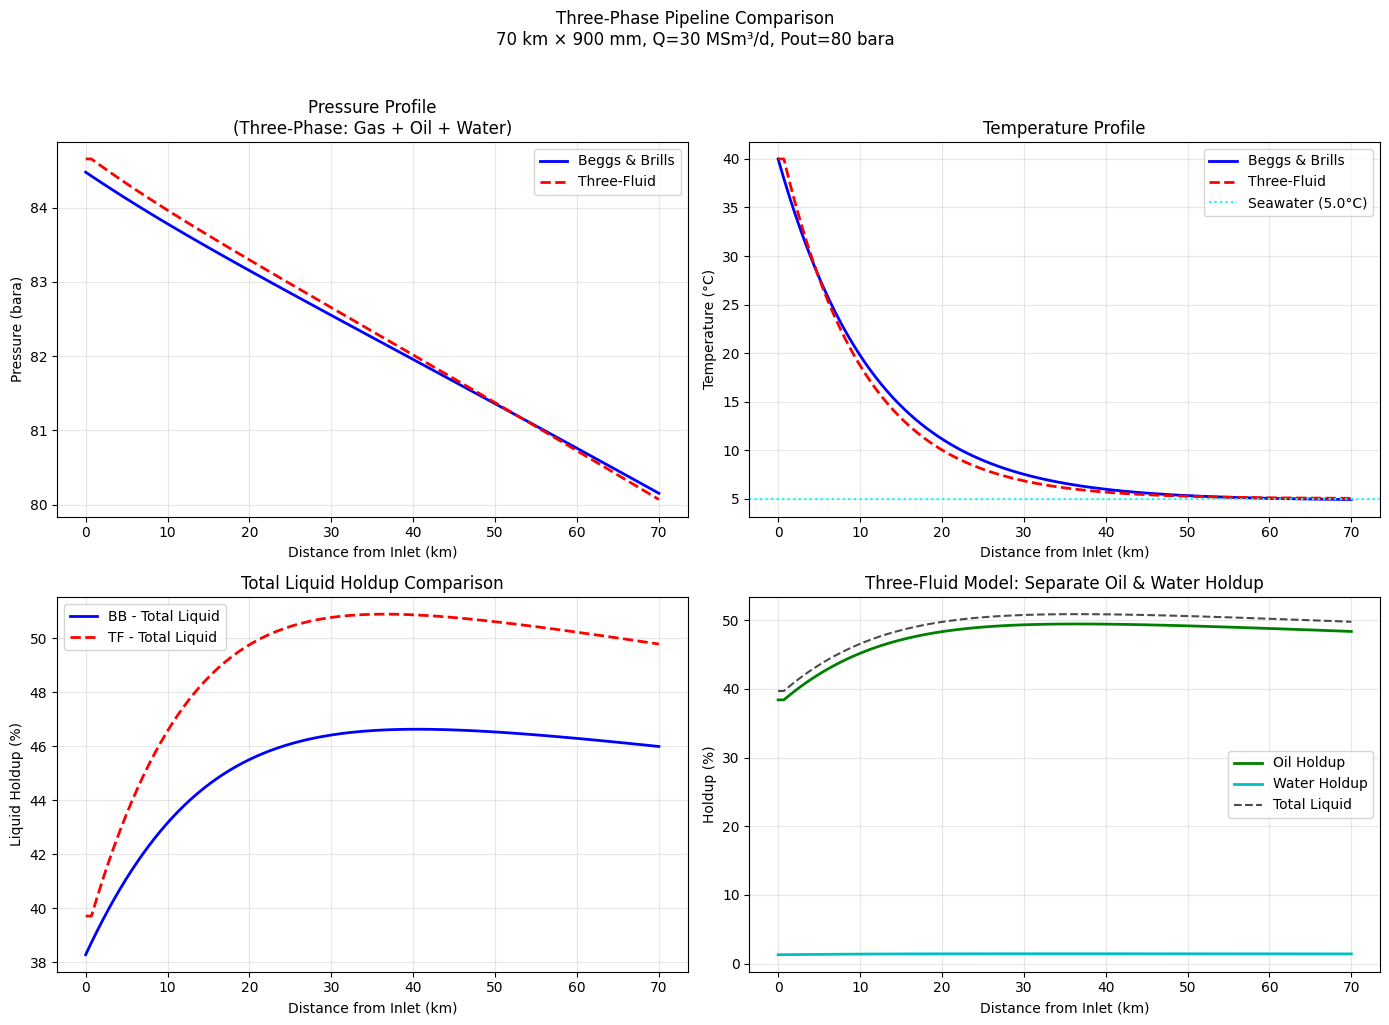


✓ Saved: output/three_phase_pipeline_comparison.png

THREE-PHASE MODEL COMPARISON

┌────────────────────────┬─────────────────────┬─────────────────────┐
│ Property               │ Beggs & Brills      │ Three-Fluid Model   │
├────────────────────────┼─────────────────────┼─────────────────────┤
│ Pressure Drop          │            4.3 bar  │            4.6 bar  │
│ Outlet Temperature     │            4.9 °C   │            5.0 °C   │
│ Avg Liquid Holdup      │          45.29 %   │          49.13 %   │
│ Avg Oil Holdup         │     N/A (combined) │          47.72 %   │
│ Avg Water Holdup       │     N/A (combined) │           1.41 %   │
└────────────────────────┴─────────────────────┴─────────────────────┘

💡 Key Insight:
   The Three-Fluid model tracks OIL and WATER separately, allowing prediction of:
   - Water accumulation in low points (corrosion risk)
   - Oil-water stratification vs emulsion formation
   - Terrain-induced phase redistribution


In [29]:
# === PLOT THREE-PHASE PIPELINE PROFILES ===
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Pressure Profile
ax1 = axes[0, 0]
if results_3p['bb']:
    ax1.plot(results_3p['bb']['distance_km'], results_3p['bb']['pressure_bara'], 
             'b-', label='Beggs & Brills', lw=2)
if results_3p['tf']:
    ax1.plot(results_3p['tf']['distance_km'], results_3p['tf']['pressure_bara'], 
             'r--', label='Three-Fluid', lw=2)
ax1.set_xlabel('Distance from Inlet (km)')
ax1.set_ylabel('Pressure (bara)')
ax1.set_title('Pressure Profile\n(Three-Phase: Gas + Oil + Water)')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Temperature Profile  
ax2 = axes[0, 1]
if results_3p['bb']:
    ax2.plot(results_3p['bb']['distance_km'], results_3p['bb']['temperature_C'], 
             'b-', label='Beggs & Brills', lw=2)
if results_3p['tf']:
    ax2.plot(results_3p['tf']['distance_km'], results_3p['tf']['temperature_C'], 
             'r--', label='Three-Fluid', lw=2)
ax2.axhline(y=SEAWATER_TEMP_C, color='cyan', ls=':', lw=1.5, label=f'Seawater ({SEAWATER_TEMP_C}°C)')
ax2.set_xlabel('Distance from Inlet (km)')
ax2.set_ylabel('Temperature (°C)')
ax2.set_title('Temperature Profile')
ax2.legend()
ax2.grid(alpha=0.3)

# Plot 3: Total Liquid Holdup Comparison
ax3 = axes[1, 0]
if results_3p['bb']:
    ax3.plot(results_3p['bb']['distance_km'], results_3p['bb']['liquid_holdup_pct'], 
             'b-', label='BB - Total Liquid', lw=2)
if results_3p['tf']:
    ax3.plot(results_3p['tf']['distance_km'], results_3p['tf']['liquid_holdup_pct'], 
             'r--', label='TF - Total Liquid', lw=2)
ax3.set_xlabel('Distance from Inlet (km)')
ax3.set_ylabel('Liquid Holdup (%)')
ax3.set_title('Total Liquid Holdup Comparison')
ax3.legend()
ax3.grid(alpha=0.3)

# Plot 4: Oil vs Water Holdup (Three-Fluid model only)
ax4 = axes[1, 1]
if results_3p['tf']:
    ax4.plot(results_3p['tf']['distance_km'], results_3p['tf']['oil_holdup_pct'], 
             'g-', label='Oil Holdup', lw=2)
    ax4.plot(results_3p['tf']['distance_km'], results_3p['tf']['water_holdup_pct'], 
             'c-', label='Water Holdup', lw=2)
    ax4.plot(results_3p['tf']['distance_km'], results_3p['tf']['liquid_holdup_pct'], 
             'k--', label='Total Liquid', lw=1.5, alpha=0.7)
ax4.set_xlabel('Distance from Inlet (km)')
ax4.set_ylabel('Holdup (%)')
ax4.set_title('Three-Fluid Model: Separate Oil & Water Holdup')
ax4.legend()
ax4.grid(alpha=0.3)

plt.suptitle(f'Three-Phase Pipeline Comparison\n'
             f'{PIPE_LENGTH/1000:.0f} km × {PIPE_DIAMETER*1000:.0f} mm, Q=30 MSm³/d, Pout=80 bara',
             fontsize=12, y=1.02)
plt.tight_layout()
plt.savefig(f"{output_dir}/three_phase_pipeline_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved: {output_dir}/three_phase_pipeline_comparison.png")

# Model comparison summary
print("\n" + "="*60)
print("THREE-PHASE MODEL COMPARISON")
print("="*60)
print("\n┌────────────────────────┬─────────────────────┬─────────────────────┐")
print("│ Property               │ Beggs & Brills      │ Three-Fluid Model   │")
print("├────────────────────────┼─────────────────────┼─────────────────────┤")

if results_3p['bb'] and results_3p['tf']:
    bb = results_3p['bb']
    tf = results_3p['tf']
    
    dp_bb = bb['inlet_p'] - bb['outlet_p']
    dp_tf = tf['inlet_p'] - tf['outlet_p']
    
    print(f"│ Pressure Drop          │ {dp_bb:>14.1f} bar  │ {dp_tf:>14.1f} bar  │")
    print(f"│ Outlet Temperature     │ {bb['outlet_T']:>14.1f} °C   │ {tf['outlet_T']:>14.1f} °C   │")
    print(f"│ Avg Liquid Holdup      │ {np.mean(bb['liquid_holdup_pct']):>14.2f} %   │ {np.mean(tf['liquid_holdup_pct']):>14.2f} %   │")
    print(f"│ Avg Oil Holdup         │ {'N/A (combined)':>18} │ {np.mean(tf['oil_holdup_pct']):>14.2f} %   │")
    print(f"│ Avg Water Holdup       │ {'N/A (combined)':>18} │ {np.mean(tf['water_holdup_pct']):>14.2f} %   │")
    print("└────────────────────────┴─────────────────────┴─────────────────────┘")
    
    print("\n💡 Key Insight:")
    print("   The Three-Fluid model tracks OIL and WATER separately, allowing prediction of:")
    print("   - Water accumulation in low points (corrosion risk)")
    print("   - Oil-water stratification vs emulsion formation")
    print("   - Terrain-induced phase redistribution")

In [30]:
# === PARALLEL VFP GENERATION ===
def calculate_vfp_point(args):
    """Calculate VFP point for both models."""
    flow_msm3d, outlet_p_bara = args
    
    # Calculate with both models
    result_bb = calculate_inlet_pressure_beggs_brills(flow_msm3d, outlet_p_bara)
    result_tf = calculate_inlet_pressure_two_fluid(flow_msm3d, outlet_p_bara)
    
    return {
        'flow_msm3d': flow_msm3d,
        'outlet_p_bara': outlet_p_bara,
        'bb': result_bb,
        'tf': result_tf
    }

# Build task list
tasks = [(q, p) for p in OUTLET_PRESSURES for q in FLOW_RATES]
print(f"Running {len(tasks)} VFP points with {N_WORKERS} workers...")
print(f"Flow rates: {FLOW_RATES} MSm³/day")
print(f"Outlet pressures: {OUTLET_PRESSURES} bara")
print()

# Run parallel calculations
results = []
start_time = time.time()

with ThreadPoolExecutor(max_workers=N_WORKERS) as executor:
    futures = {executor.submit(calculate_vfp_point, t): t for t in tasks}
    for i, future in enumerate(as_completed(futures), 1):
        r = future.result()
        results.append(r)
        
        # Status update
        bb = r['bb']
        tf = r['tf']
        
        bb_status = f"Pin={bb['inlet_p_bara']:.1f}" if bb.get('feasible') else "FAIL"
        tf_status = f"Pin={tf['inlet_p_bara']:.1f}" if tf.get('feasible') else "FAIL"
        
        print(f"[{i:2d}/{len(tasks)}] Q={r['flow_msm3d']:.0f}, Pout={r['outlet_p_bara']:.0f} → BB:{bb_status}, TF:{tf_status}")

elapsed = time.time() - start_time
print(f"\n{'='*60}")
print(f"Complete: {len(results)} points in {elapsed:.1f}s ({elapsed/len(results):.2f}s/point)")

Running 42 VFP points with 8 workers...
Flow rates: [10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0] MSm³/day
Outlet pressures: [70.0, 75.0, 80.0, 85.0, 90.0, 95.0] bara

[ 1/42] Q=30, Pout=70 → BB:Pin=79.3, TF:Pin=79.8
[ 2/42] Q=35, Pout=70 → BB:Pin=83.4, TF:Pin=82.9
[ 3/42] Q=20, Pout=70 → BB:Pin=75.2, TF:Pin=74.7
[ 4/42] Q=25, Pout=70 → BB:Pin=77.0, TF:Pin=77.0
[ 5/42] Q=40, Pout=70 → BB:Pin=88.2, TF:Pin=86.4
[ 6/42] Q=25, Pout=75 → BB:Pin=81.9, TF:Pin=81.5
[ 7/42] Q=35, Pout=75 → BB:Pin=87.1, TF:Pin=87.0
[ 8/42] Q=30, Pout=75 → BB:Pin=83.3, TF:Pin=84.1
[ 9/42] Q=40, Pout=75 → BB:Pin=91.5, TF:Pin=90.3
[10/42] Q=10, Pout=75 → BB:Pin=83.2, TF:Pin=76.2
[11/42] Q=10, Pout=70 → BB:Pin=78.3, TF:Pin=71.3
[12/42] Q=15, Pout=70 → BB:Pin=100.0, TF:Pin=72.7
[13/42] Q=15, Pout=75 → BB:Pin=105.0, TF:Pin=77.5
[14/42] Q=25, Pout=80 → BB:Pin=86.7, TF:Pin=86.0
[15/42] Q=30, Pout=80 → BB:Pin=88.0, TF:Pin=88.4
[16/42] Q=20, Pout=75 → BB:Pin=85.4, TF:Pin=79.3
[17/42] Q=35, Pout=80 → BB:Pin=91.0, TF:Pin=91.2


In [31]:
# === CREATE DATAFRAMES ===
# Beggs & Brills results - use target outlet pressure from task, not calculated
bb_data = []
for r in results:
    bb = r['bb']
    if bb.get('feasible'):
        bb_data.append({
            'model': 'Beggs & Brills',
            'flow_msm3d': r['flow_msm3d'],  # Use task's flow rate
            'outlet_p_bara': r['outlet_p_bara'],  # Use task's target outlet pressure
            'inlet_p_bara': bb['inlet_p_bara'],
            'pressure_drop_bar': bb['pressure_drop_bar'],
            'avg_holdup_pct': bb['avg_holdup'] * 100,
            'max_holdup_pct': bb['max_holdup'] * 100,
            'liquid_inventory_m3': bb['liquid_inventory_m3'],
            'constraint_satisfied': bb['constraint_satisfied']
        })

# Two-Fluid results - use target outlet pressure from task, not calculated
tf_data = []
for r in results:
    tf = r['tf']
    if tf.get('feasible'):
        tf_data.append({
            'model': 'Two-Fluid (OLGA)',
            'flow_msm3d': r['flow_msm3d'],  # Use task's flow rate
            'outlet_p_bara': r['outlet_p_bara'],  # Use task's target outlet pressure
            'inlet_p_bara': tf['inlet_p_bara'],
            'pressure_drop_bar': tf['pressure_drop_bar'],
            'avg_holdup_pct': tf['avg_holdup'] * 100,
            'max_holdup_pct': tf['max_holdup'] * 100,
            'liquid_inventory_m3': tf['liquid_inventory_m3'],
            'constraint_satisfied': tf['constraint_satisfied']
        })

bb_df = pd.DataFrame(bb_data)
tf_df = pd.DataFrame(tf_data)
combined_df = pd.concat([bb_df, tf_df], ignore_index=True)

print(f"Beggs & Brills: {len(bb_df)} successful points")
print(f"Two-Fluid: {len(tf_df)} successful points")

# Display comparison table
print("\n=== MODEL COMPARISON (Inlet Pressure, bara) ===")
if not bb_df.empty and not tf_df.empty:
    pivot_bb = bb_df.pivot(index='flow_msm3d', columns='outlet_p_bara', values='inlet_p_bara')
    pivot_tf = tf_df.pivot(index='flow_msm3d', columns='outlet_p_bara', values='inlet_p_bara')
    
    print("\nBeggs & Brills:")
    print(pivot_bb.to_string())
    print("\nTwo-Fluid (OLGA):")
    print(pivot_tf.to_string())
    
    # Calculate difference
    print("\nDifference (TF - BB):")
    print((pivot_tf - pivot_bb).to_string())

Beggs & Brills: 42 successful points
Two-Fluid: 42 successful points

=== MODEL COMPARISON (Inlet Pressure, bara) ===

Beggs & Brills:
outlet_p_bara        70.0        75.0        80.0        85.0        90.0        95.0
flow_msm3d                                                                           
10.0            78.286300   83.238437   88.196102   93.158499   98.124974  103.094986
15.0           100.000000  105.000000  110.000000  115.000000  120.000000  125.000000
20.0            75.162143   85.391967   85.058551  115.000000  120.000000  125.000000
25.0            77.039784   81.934226   86.720360   91.393201   96.075689  100.695280
30.0            79.309554   83.328034   88.017866   93.250904   98.104492  102.929432
35.0            83.430456   87.128348   90.980305   94.985082   99.105309  104.380837
40.0            88.176929   91.545211   95.134013   98.851479  102.689294  106.693594

Two-Fluid (OLGA):
outlet_p_bara       70.0       75.0       80.0       85.0        90.0   

In [32]:
# === LIQUID INVENTORY COMPARISON TABLE ===
print("=== LIQUID INVENTORY COMPARISON (m³) ===")
print("\nBeggs & Brills:")
bb_hold = bb_df.pivot(index='flow_msm3d', columns='outlet_p_bara', values='liquid_inventory_m3')
print(bb_hold.to_string(float_format='%.1f'))

print("\nTwo-Fluid (OLGA):")
tf_hold = tf_df.pivot(index='flow_msm3d', columns='outlet_p_bara', values='liquid_inventory_m3')
print(tf_hold.to_string(float_format='%.1f'))

print("\nAverage Holdup (%):")
print("Beggs & Brills:")
bb_80 = bb_df.pivot(index='flow_msm3d', columns='outlet_p_bara', values='avg_holdup_pct')
print(bb_80.to_string(float_format='%.2f'))

print("\nTwo-Fluid (OLGA):")
tf_80 = tf_df.pivot(index='flow_msm3d', columns='outlet_p_bara', values='avg_holdup_pct')
print(tf_80.to_string(float_format='%.2f'))

=== LIQUID INVENTORY COMPARISON (m³) ===

Beggs & Brills:
outlet_p_bara  70.0   75.0   80.0   85.0   90.0   95.0
flow_msm3d                                            
10.0          882.9  927.0  970.5 1013.2 1055.2 1096.3
15.0          987.7 1026.0 1063.4 1099.8 1135.3 1169.8
20.0          734.7  816.8  814.1 1035.1 1069.0 1101.8
25.0          710.1  747.0  783.1  818.0  852.4  885.6
30.0          692.4  724.4  758.8  794.7  828.1  861.0
35.0          685.7  715.1  744.7  774.6  804.3  838.3
40.0          683.8  710.6  738.2  765.8  793.3  821.0

Two-Fluid (OLGA):
outlet_p_bara  70.0  75.0  80.0  85.0  90.0   95.0
flow_msm3d                                        
10.0          445.3 445.3 445.3 916.1 975.1 1024.7
15.0          445.3 445.3 445.3 445.3 459.4  477.9
20.0          445.3 445.3 445.3 445.3 447.3  463.3
25.0          445.3 445.3 445.3 445.3 445.3  453.6
30.0          445.3 445.3 445.3 445.3 445.3  447.4
35.0          445.3 445.3 445.3 445.3 445.3  445.3
40.0          445.3 

In [33]:
# === DEBUG: Check flow regime and velocities ===
test_flow = 20.0  # Low flow rate
test_pout = 80.0

fluid = create_feed_fluid()
flow_kg_hr = test_flow * GAS_DENSITY_STD * 1e6 / 24.0
inlet = Stream("Debug Inlet", fluid)
inlet.setFlowRate(flow_kg_hr, "kg/hr")
inlet.setTemperature(INLET_TEMP_C, "C")
inlet.setPressure(90.0, "bara")
inlet.run()

pipe_dbg = TwoFluidPipe("Debug Pipeline", inlet)
pipe_dbg.setLength(PIPE_LENGTH)
pipe_dbg.setDiameter(PIPE_DIAMETER)
pipe_dbg.setRoughness(PIPE_ROUGHNESS)
pipe_dbg.setNumberOfSections(10)  # Fewer sections for debugging

from jpype.types import JArray, JDouble
elevations = JArray(JDouble)(10)
for i in range(10):
    elevations[i] = 0.0
pipe_dbg.setElevationProfile(elevations)
pipe_dbg.run()

# Check profiles
print(f"=== DEBUG at Q={test_flow} MSm³/d ===")
flow_regimes = pipe_dbg.getFlowRegimeProfile()
liquid_holdup = pipe_dbg.getLiquidHoldupProfile()
gas_velocity = pipe_dbg.getGasVelocityProfile()
liquid_velocity = pipe_dbg.getLiquidVelocityProfile()

print(f"Flow regimes along pipe: {[str(r) for r in flow_regimes[:3]]}...")
print(f"First 3 liquid holdups: {[f'{h*100:.2f}%' for h in liquid_holdup[:3]]}")
print(f"First 3 gas velocities: {[f'{v:.2f} m/s' for v in gas_velocity[:3]]}")
print(f"First 3 liquid velocities: {[f'{v:.2f} m/s' for v in liquid_velocity[:3]]}")

# Calculate superficial velocities
pipe_area = np.pi * (PIPE_DIAMETER / 2) ** 2
rhoG_est = 65.0  # kg/m³ at ~85 bara
mass_flow_kg_s = flow_kg_hr / 3600.0
vsG_est = mass_flow_kg_s / (pipe_area * rhoG_est)
print(f"\nEstimated superficial gas velocity: {vsG_est:.2f} m/s")
print(f"At vsG={vsG_est:.2f}, velocity ratio vsgRef/vsG = {8.0/vsG_est:.2f}")
print(f"Slip factor = 1.5 * {(8.0/vsG_est):.2f}^0.5 = {1.5 * (8.0/vsG_est)**0.5:.2f}")

=== DEBUG at Q=20.0 MSm³/d ===
Flow regimes along pipe: ['ANNULAR', 'ANNULAR', 'ANNULAR']...
First 3 liquid holdups: ['1.00%', '1.00%', '1.00%']
First 3 gas velocities: ['4.14 m/s', '4.14 m/s', '4.16 m/s']
First 3 liquid velocities: ['0.08 m/s', '0.08 m/s', '0.08 m/s']

Estimated superficial gas velocity: 4.20 m/s
At vsG=4.20, velocity ratio vsgRef/vsG = 1.91
Slip factor = 1.5 * 1.91^0.5 = 2.07


C:\Users\ESOL\AppData\Local\Temp\ipykernel_14108\888346342.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend()


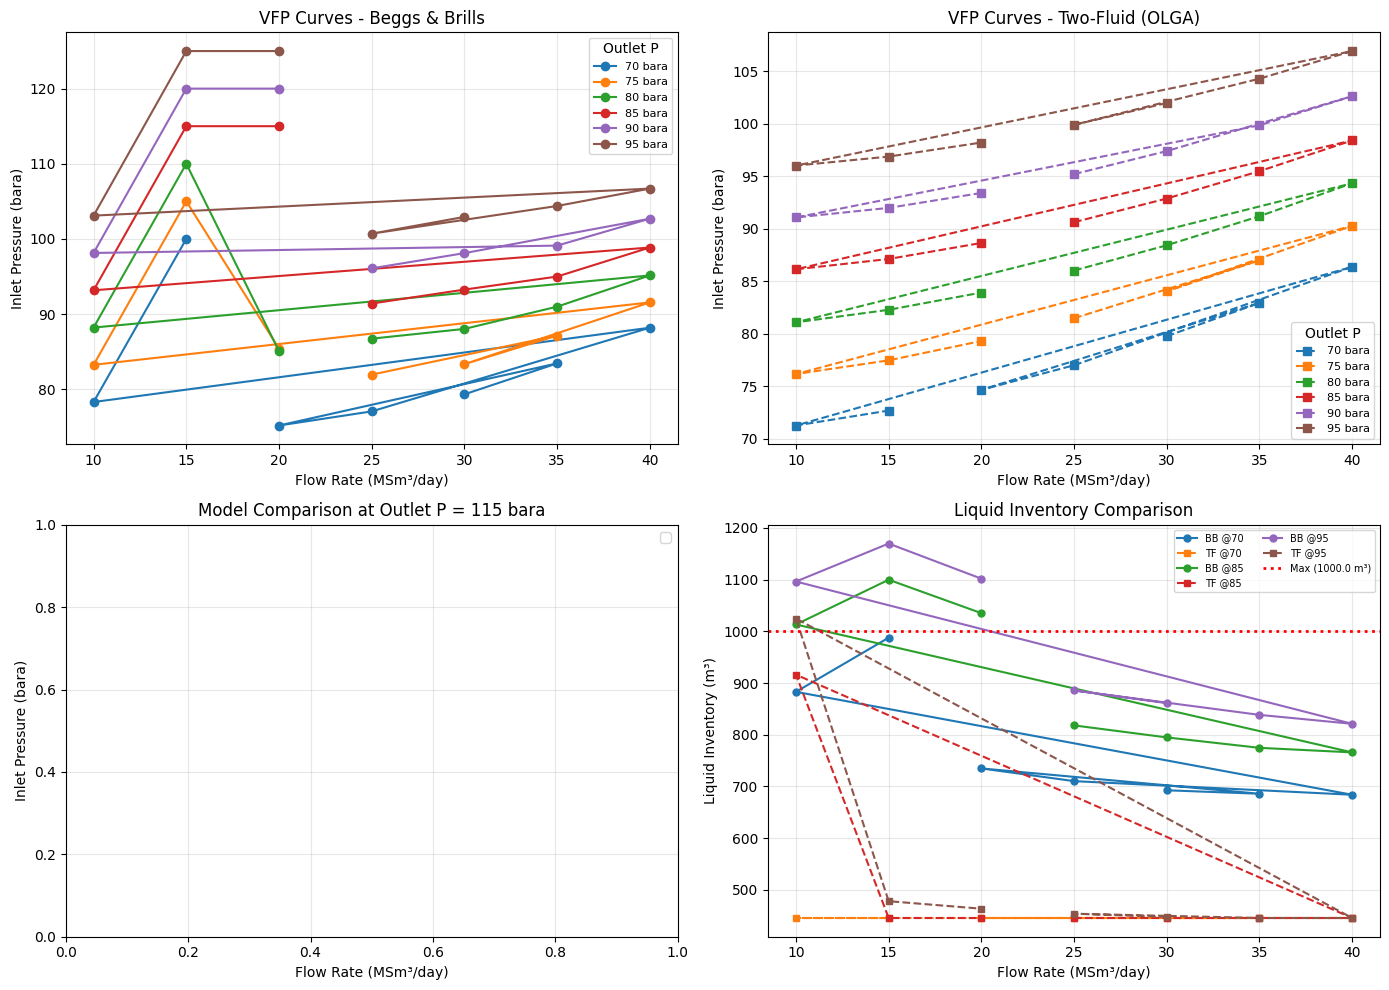


✓ Saved: output/vfp_pipeline_model_comparison.png


In [34]:
# === VFP CURVES VISUALIZATION ===
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: VFP Curves - Beggs & Brills
ax1 = axes[0, 0]
for p in OUTLET_PRESSURES:
    df_p = bb_df[bb_df['outlet_p_bara'] == p]
    if not df_p.empty:
        ax1.plot(df_p['flow_msm3d'], df_p['inlet_p_bara'], 'o-', label=f'{p:.0f} bara', ms=6)
ax1.set_xlabel('Flow Rate (MSm³/day)')
ax1.set_ylabel('Inlet Pressure (bara)')
ax1.set_title('VFP Curves - Beggs & Brills')
ax1.legend(fontsize=8, title='Outlet P')
ax1.grid(alpha=0.3)

# Plot 2: VFP Curves - Two-Fluid
ax2 = axes[0, 1]
for p in OUTLET_PRESSURES:
    df_p = tf_df[tf_df['outlet_p_bara'] == p]
    if not df_p.empty:
        ax2.plot(df_p['flow_msm3d'], df_p['inlet_p_bara'], 's--', label=f'{p:.0f} bara', ms=6)
ax2.set_xlabel('Flow Rate (MSm³/day)')
ax2.set_ylabel('Inlet Pressure (bara)')
ax2.set_title('VFP Curves - Two-Fluid (OLGA)')
ax2.legend(fontsize=8, title='Outlet P')
ax2.grid(alpha=0.3)

# Plot 3: Model Comparison at fixed outlet pressure
ax3 = axes[1, 0]
p_compare = 115.0  # bara
bb_compare = bb_df[bb_df['outlet_p_bara'] == p_compare]
tf_compare = tf_df[tf_df['outlet_p_bara'] == p_compare]
if not bb_compare.empty:
    ax3.plot(bb_compare['flow_msm3d'], bb_compare['inlet_p_bara'], 'o-', label='Beggs & Brills', ms=8, lw=2)
if not tf_compare.empty:
    ax3.plot(tf_compare['flow_msm3d'], tf_compare['inlet_p_bara'], 's--', label='Two-Fluid (OLGA)', ms=8, lw=2)
ax3.set_xlabel('Flow Rate (MSm³/day)')
ax3.set_ylabel('Inlet Pressure (bara)')
ax3.set_title(f'Model Comparison at Outlet P = {p_compare:.0f} bara')
ax3.legend()
ax3.grid(alpha=0.3)

# Plot 4: Liquid Inventory Comparison
ax4 = axes[1, 1]
for p in [OUTLET_PRESSURES[0], OUTLET_PRESSURES[len(OUTLET_PRESSURES)//2], OUTLET_PRESSURES[-1]]:
    bb_liq = bb_df[bb_df['outlet_p_bara'] == p]
    tf_liq = tf_df[tf_df['outlet_p_bara'] == p]
    if not bb_liq.empty:
        ax4.plot(bb_liq['flow_msm3d'], bb_liq['liquid_inventory_m3'], 'o-', label=f'BB @{p:.0f}', ms=5)
    if not tf_liq.empty:
        ax4.plot(tf_liq['flow_msm3d'], tf_liq['liquid_inventory_m3'], 's--', label=f'TF @{p:.0f}', ms=5)

ax4.axhline(y=MAX_LIQUID_INVENTORY_M3, color='r', linestyle=':', linewidth=2, label=f'Max ({MAX_LIQUID_INVENTORY_M3} m³)')
ax4.set_xlabel('Flow Rate (MSm³/day)')
ax4.set_ylabel('Liquid Inventory (m³)')
ax4.set_title('Liquid Inventory Comparison')
ax4.legend(fontsize=7, ncol=2)
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f"{output_dir}/vfp_pipeline_model_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved: {output_dir}/vfp_pipeline_model_comparison.png")

C:\Users\ESOL\AppData\Local\Temp\ipykernel_14108\935988664.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


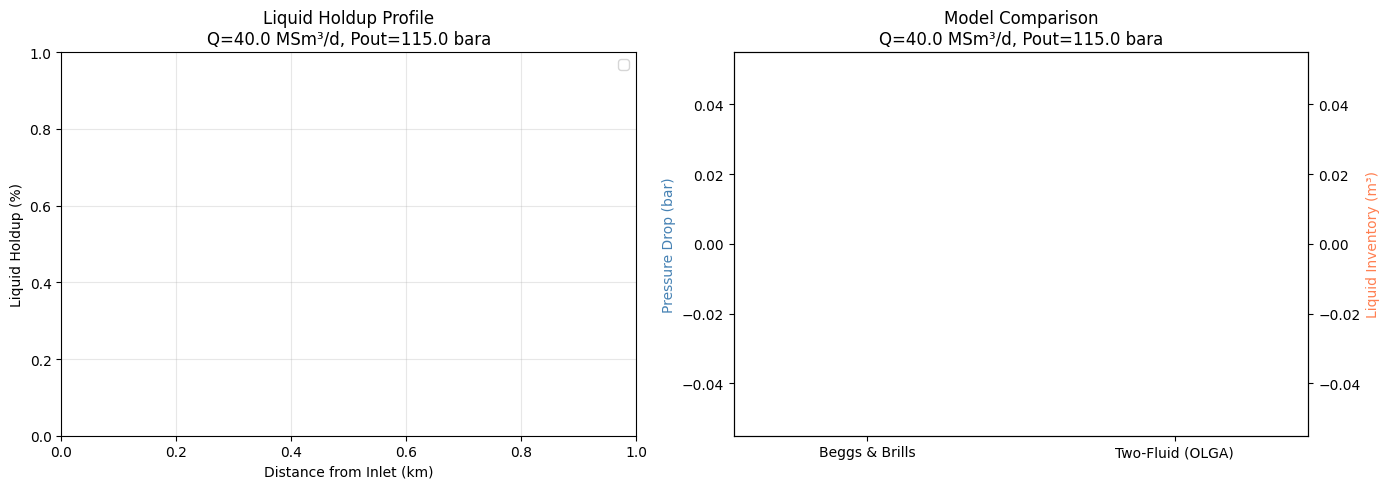


✓ Saved: output/holdup_profile_comparison.png


In [35]:
# === LIQUID HOLDUP PROFILE COMPARISON ===
# Compare holdup profiles for a single operating point

test_flow = 40.0  # MSm³/day (middle of range)
test_pout = 115.0  # bara

# Get profiles from stored results
bb_result = None
tf_result = None
for r in results:
    if r['flow_msm3d'] == test_flow and r['outlet_p_bara'] == test_pout:
        bb_result = r['bb']
        tf_result = r['tf']
        break

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Holdup profiles along pipeline
if bb_result and bb_result.get('feasible') and 'holdup_profile' in bb_result:
    bb_holdup = bb_result['holdup_profile']
    bb_x = np.linspace(0, PIPE_LENGTH/1000, len(bb_holdup))
    ax1.plot(bb_x, np.array(bb_holdup)*100, 'b-', label='Beggs & Brills', lw=2)

if tf_result and tf_result.get('feasible') and 'holdup_profile' in tf_result:
    tf_holdup = tf_result['holdup_profile']
    tf_x = np.linspace(0, PIPE_LENGTH/1000, len(tf_holdup))
    ax1.plot(tf_x, np.array(tf_holdup)*100, 'r--', label='Two-Fluid (OLGA)', lw=2)

ax1.set_xlabel('Distance from Inlet (km)')
ax1.set_ylabel('Liquid Holdup (%)')
ax1.set_title(f'Liquid Holdup Profile\nQ={test_flow} MSm³/d, Pout={test_pout} bara')
ax1.legend()
ax1.grid(alpha=0.3)

# Pressure drop comparison bar chart
models = ['Beggs & Brills', 'Two-Fluid (OLGA)']
dps = [
    bb_result.get('pressure_drop_bar', 0) if bb_result and bb_result.get('feasible') else 0,
    tf_result.get('pressure_drop_bar', 0) if tf_result and tf_result.get('feasible') else 0
]
inventories = [
    bb_result.get('liquid_inventory_m3', 0) if bb_result and bb_result.get('feasible') else 0,
    tf_result.get('liquid_inventory_m3', 0) if tf_result and tf_result.get('feasible') else 0
]

x = np.arange(len(models))
width = 0.35

bars1 = ax2.bar(x - width/2, dps, width, label='Pressure Drop (bar)', color='steelblue')
ax2_twin = ax2.twinx()
bars2 = ax2_twin.bar(x + width/2, inventories, width, label='Liquid Inventory (m³)', color='coral')

ax2.set_ylabel('Pressure Drop (bar)', color='steelblue')
ax2_twin.set_ylabel('Liquid Inventory (m³)', color='coral')
ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.set_title(f'Model Comparison\nQ={test_flow} MSm³/d, Pout={test_pout} bara')

# Add value labels
for bar, val in zip(bars1, dps):
    if val > 0:
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{val:.1f}', ha='center', fontsize=10)
for bar, val in zip(bars2, inventories):
    if val > 0:
        ax2_twin.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, f'{val:.0f}', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig(f"{output_dir}/holdup_profile_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved: {output_dir}/holdup_profile_comparison.png")

In [36]:
# === GENERATE ECLIPSE VFP FILE ===
def generate_eclipse_vfp(df, model_name, table_num=1):
    """Generate Eclipse VFPPROD table from results.
    
    Args:
        df: DataFrame with VFP results
        model_name: Model name for comments
        table_num: VFP table number
    
    Returns:
        str: Eclipse VFPPROD include file content
    """
    flows = sorted(df['flow_msm3d'].unique())
    thps = sorted(df['outlet_p_bara'].unique())
    
    lines = [
        f"-- Eclipse VFPPROD - Generated {datetime.now():%Y-%m-%d %H:%M}",
        f"-- Pipeline VFP using {model_name} model",
        f"-- Pipeline: {PIPE_LENGTH/1000:.0f} km, {PIPE_DIAMETER*1000:.0f} mm ID",
        f"-- THP = Pipeline outlet pressure (bara)",
        f"-- BHP = Pipeline inlet pressure (bara)",
        "",
        "VFPPROD",
        f"   {table_num}  0.0  GAS  WCT  GOR  THP  ''  METRIC /",
        "",
        "-- Flow rates (1000 Sm3/d)",
        "  " + "  ".join(f"{q*1000:.1f}" for q in flows) + " /",
        "",
        "-- THP values (bara)",
        "  " + "  ".join(f"{p:.1f}" for p in thps) + " /",
        "",
        "-- WCT values",
        "  0.0 /",
        "",
        "-- GOR values",
        "  999999 /",
        "",
        "-- ALQ values",
        "  0 /",
        "",
        "-- BHP values (bara)"
    ]
    
    for thp in thps:
        bhps = []
        for q in flows:
            row = df[(df['outlet_p_bara'] == thp) & (df['flow_msm3d'] == q)]
            if not row.empty:
                bhps.append(f"{row['inlet_p_bara'].values[0]:.2f}")
            else:
                bhps.append("1*")  # Eclipse default marker
        lines.append(f"  {' '.join(bhps)} /  -- THP={thp:.0f} bara")
    
    lines.extend(["", "/", ""])
    
    # Add liquid inventory table as comments
    lines.extend([
        "-- ================================================",
        "-- LIQUID INVENTORY TABLE (m3)",
        f"-- Constraint: Max {MAX_LIQUID_INVENTORY_M3} m3",
        "-- Rows: THP (bara), Cols: Flow (MSm3/d)",
        "-- ================================================"
    ])
    
    header = "-- THP    " + "  ".join(f"{q:8.0f}" for q in flows)
    lines.append(header)
    
    for thp in thps:
        values = []
        for q in flows:
            row = df[(df['outlet_p_bara'] == thp) & (df['flow_msm3d'] == q)]
            if not row.empty and 'liquid_inventory_m3' in row.columns:
                inv = row['liquid_inventory_m3'].values[0]
                flag = "*" if inv > MAX_LIQUID_INVENTORY_M3 else " "
                values.append(f"{inv:7.0f}{flag}")
            else:
                values.append("     N/A")
        lines.append(f"-- {thp:5.0f}  " + "  ".join(values))
    
    lines.append("-- ================================================")
    lines.append("-- * = Exceeds liquid inventory constraint")
    
    return "\n".join(lines)

# Generate VFP files for both models
if not bb_df.empty:
    vfp_bb = generate_eclipse_vfp(bb_df, "Beggs & Brills", table_num=1)
    with open(f"{output_dir}/VFPPROD_pipeline_BB.INC", 'w') as f:
        f.write(vfp_bb)
    print("Beggs & Brills VFP:")
    print(vfp_bb)
    print()

if not tf_df.empty:
    vfp_tf = generate_eclipse_vfp(tf_df, "Two-Fluid (OLGA)", table_num=2)
    with open(f"{output_dir}/VFPPROD_pipeline_TF.INC", 'w') as f:
        f.write(vfp_tf)
    print("\nTwo-Fluid (OLGA) VFP:")
    print(vfp_tf)

print(f"\n✓ Saved: {output_dir}/VFPPROD_pipeline_BB.INC")
print(f"✓ Saved: {output_dir}/VFPPROD_pipeline_TF.INC")

Beggs & Brills VFP:
-- Eclipse VFPPROD - Generated 2026-01-25 22:20
-- Pipeline VFP using Beggs & Brills model
-- Pipeline: 70 km, 900 mm ID
-- THP = Pipeline outlet pressure (bara)
-- BHP = Pipeline inlet pressure (bara)

VFPPROD
   1  0.0  GAS  WCT  GOR  THP  ''  METRIC /

-- Flow rates (1000 Sm3/d)
  10000.0  15000.0  20000.0  25000.0  30000.0  35000.0  40000.0 /

-- THP values (bara)
  70.0  75.0  80.0  85.0  90.0  95.0 /

-- WCT values
  0.0 /

-- GOR values
  999999 /

-- ALQ values
  0 /

-- BHP values (bara)
  78.29 100.00 75.16 77.04 79.31 83.43 88.18 /  -- THP=70 bara
  83.24 105.00 85.39 81.93 83.33 87.13 91.55 /  -- THP=75 bara
  88.20 110.00 85.06 86.72 88.02 90.98 95.13 /  -- THP=80 bara
  93.16 115.00 115.00 91.39 93.25 94.99 98.85 /  -- THP=85 bara
  98.12 120.00 120.00 96.08 98.10 99.11 102.69 /  -- THP=90 bara
  103.09 125.00 125.00 100.70 102.93 104.38 106.69 /  -- THP=95 bara

/

-- ================================================
-- LIQUID INVENTORY TABLE (m3)
-- C

In [37]:
# === SAVE DETAILED RESULTS ===
# Save combined results
combined_df.to_csv(f"{output_dir}/vfp_pipeline_detailed.csv", index=False)

# Create summary statistics
summary = {
    'Pipeline Length (km)': PIPE_LENGTH / 1000,
    'Pipeline Diameter (mm)': PIPE_DIAMETER * 1000,
    'Flow Rate Range (MSm3/d)': f"{min(FLOW_RATES)} - {max(FLOW_RATES)}",
    'Outlet Pressure Range (bara)': f"{min(OUTLET_PRESSURES)} - {max(OUTLET_PRESSURES)}",
    'Max Liquid Inventory Constraint (m3)': MAX_LIQUID_INVENTORY_M3,
    'BB Points Calculated': int(len(bb_df)),
    'TF Points Calculated': int(len(tf_df))
}

if not bb_df.empty:
    summary['BB Avg Pressure Drop (bar)'] = float(bb_df['pressure_drop_bar'].mean())
    summary['BB Avg Liquid Inventory (m3)'] = float(bb_df['liquid_inventory_m3'].mean())
    summary['BB Points Within Constraint'] = int(bb_df['constraint_satisfied'].sum())

if not tf_df.empty:
    summary['TF Avg Pressure Drop (bar)'] = float(tf_df['pressure_drop_bar'].mean())
    summary['TF Avg Liquid Inventory (m3)'] = float(tf_df['liquid_inventory_m3'].mean())
    summary['TF Points Within Constraint'] = int(tf_df['constraint_satisfied'].sum())

print("=== SIMULATION SUMMARY ===")
for key, value in summary.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.2f}")
    else:
        print(f"  {key}: {value}")

# Save summary as JSON
import json
with open(f"{output_dir}/vfp_pipeline_summary.json", 'w') as f:
    json.dump(summary, f, indent=2)

print(f"\n✓ Saved: {output_dir}/vfp_pipeline_detailed.csv")
print(f"✓ Saved: {output_dir}/vfp_pipeline_summary.json")

=== SIMULATION SUMMARY ===
  Pipeline Length (km): 70.00
  Pipeline Diameter (mm): 900.00
  Flow Rate Range (MSm3/d): 10.0 - 40.0
  Outlet Pressure Range (bara): 70.0 - 95.0
  Max Liquid Inventory Constraint (m3): 1000.00
  BB Points Calculated: 42
  TF Points Calculated: 42
  BB Avg Pressure Drop (bar): 6.70
  BB Avg Liquid Inventory (m3): 869.76
  BB Points Within Constraint: 31
  TF Avg Pressure Drop (bar): 6.59
  TF Avg Liquid Inventory (m3): 484.77
  TF Points Within Constraint: 41

✓ Saved: output/vfp_pipeline_detailed.csv
✓ Saved: output/vfp_pipeline_summary.json


=== LIQUID INVENTORY VS FLOW RATE ===

Beggs & Brills (liquid inventory increases at low flow - expected behavior):
outlet_p_bara        70.0         75.0         80.0         85.0         90.0         95.0
flow_msm3d                                                                                
10.0           882.917346   927.032733   970.476519  1013.206680  1055.172190  1096.317628
15.0           987.709572  1025.979256  1063.360305  1099.815287  1135.310627  1169.819434
20.0           734.710909   816.752057   814.128463  1035.147513  1068.964834  1101.832970
25.0           710.146989   746.984072   783.053364   817.965814   852.361400   885.626299
30.0           692.443211   724.448913   758.827647   794.738567   828.122217   860.997496
35.0           685.724035   715.132326   744.746701   774.565866   804.315463   838.329515
40.0           683.781280   710.637552   738.198831   765.751405   793.251494   821.018765

Two-Fluid (OLGA):
outlet_p_bara        70.0        75.0        8

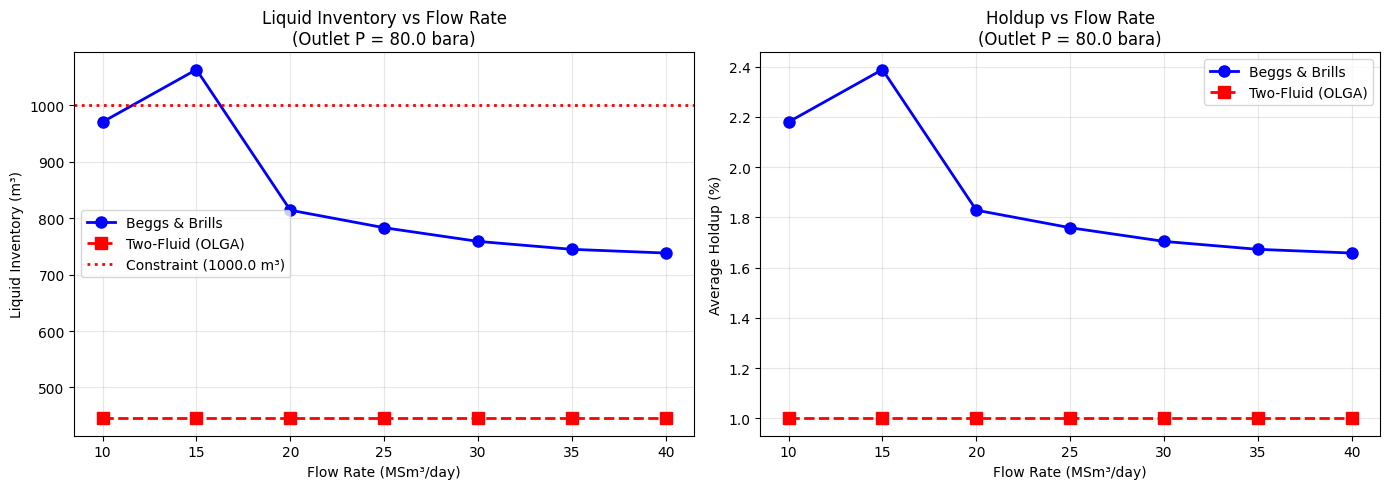


✓ Saved: output/low_flow_liquid_inventory.png

=== LOW-FLOW BEHAVIOR ANALYSIS ===
Beggs & Brills: Low flow (10.0 MSm³/d) = 970 m³, High flow (40.0 MSm³/d) = 738 m³
  → Trend: Inventory INCREASES at low flow ✓

Two-Fluid: Low flow (10.0 MSm³/d) = 445 m³, High flow (40.0 MSm³/d) = 445 m³
  → Trend: Inventory DECREASES at low flow ✗ (BUG!)


In [38]:
# === ANALYZE LOW-FLOW LIQUID INVENTORY BEHAVIOR ===
# Check if Two-Fluid model shows liquid buildup at low flow rates

print("=== LIQUID INVENTORY VS FLOW RATE ===")
print("\nBeggs & Brills (liquid inventory increases at low flow - expected behavior):")
bb_liq = bb_df.pivot(index='flow_msm3d', columns='outlet_p_bara', values='liquid_inventory_m3')
print(bb_liq.to_string())

print("\nTwo-Fluid (OLGA):")
tf_liq = tf_df.pivot(index='flow_msm3d', columns='outlet_p_bara', values='liquid_inventory_m3')
print(tf_liq.to_string())

print("\n=== HOLDUP VS FLOW RATE ===")
print("\nBeggs & Brills (holdup %):")
bb_hold = bb_df.pivot(index='flow_msm3d', columns='outlet_p_bara', values='avg_holdup_pct')
print(bb_hold.to_string())

print("\nTwo-Fluid (holdup %):")
tf_hold = tf_df.pivot(index='flow_msm3d', columns='outlet_p_bara', values='avg_holdup_pct')
print(tf_hold.to_string())

# Plot the comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Liquid inventory vs flow rate for Pout=80 bara
p_target = 80.0
bb_80 = bb_df[bb_df['outlet_p_bara'] == p_target].sort_values('flow_msm3d')
tf_80 = tf_df[tf_df['outlet_p_bara'] == p_target].sort_values('flow_msm3d')

ax1 = axes[0]
ax1.plot(bb_80['flow_msm3d'], bb_80['liquid_inventory_m3'], 'b-o', label='Beggs & Brills', lw=2, ms=8)
ax1.plot(tf_80['flow_msm3d'], tf_80['liquid_inventory_m3'], 'r--s', label='Two-Fluid (OLGA)', lw=2, ms=8)
ax1.axhline(y=MAX_LIQUID_INVENTORY_M3, color='red', ls=':', lw=2, label=f'Constraint ({MAX_LIQUID_INVENTORY_M3} m³)')
ax1.set_xlabel('Flow Rate (MSm³/day)')
ax1.set_ylabel('Liquid Inventory (m³)')
ax1.set_title(f'Liquid Inventory vs Flow Rate\n(Outlet P = {p_target} bara)')
ax1.legend()
ax1.grid(alpha=0.3)

# Expected: Inventory should INCREASE at low flow (liquid accumulates when gas velocity is too low)
# BB shows this behavior, TF should too

ax2 = axes[1]
ax2.plot(bb_80['flow_msm3d'], bb_80['avg_holdup_pct'], 'b-o', label='Beggs & Brills', lw=2, ms=8)
ax2.plot(tf_80['flow_msm3d'], tf_80['avg_holdup_pct'], 'r--s', label='Two-Fluid (OLGA)', lw=2, ms=8)
ax2.set_xlabel('Flow Rate (MSm³/day)')
ax2.set_ylabel('Average Holdup (%)')
ax2.set_title(f'Holdup vs Flow Rate\n(Outlet P = {p_target} bara)')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f"{output_dir}/low_flow_liquid_inventory.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved: {output_dir}/low_flow_liquid_inventory.png")

# Calculate the trend
print("\n=== LOW-FLOW BEHAVIOR ANALYSIS ===")
if len(bb_80) > 0 and len(tf_80) > 0:
    bb_low = bb_80.iloc[0]['liquid_inventory_m3']  # Lowest flow
    bb_high = bb_80.iloc[-1]['liquid_inventory_m3']  # Highest flow
    tf_low = tf_80.iloc[0]['liquid_inventory_m3']
    tf_high = tf_80.iloc[-1]['liquid_inventory_m3']
    
    print(f"Beggs & Brills: Low flow ({bb_80.iloc[0]['flow_msm3d']} MSm³/d) = {bb_low:.0f} m³, High flow ({bb_80.iloc[-1]['flow_msm3d']} MSm³/d) = {bb_high:.0f} m³")
    print(f"  → Trend: {'Inventory INCREASES at low flow ✓' if bb_low > bb_high else 'Inventory DECREASES at low flow ✗'}")
    
    print(f"\nTwo-Fluid: Low flow ({tf_80.iloc[0]['flow_msm3d']} MSm³/d) = {tf_low:.0f} m³, High flow ({tf_80.iloc[-1]['flow_msm3d']} MSm³/d) = {tf_high:.0f} m³")
    print(f"  → Trend: {'Inventory INCREASES at low flow ✓' if tf_low > tf_high else 'Inventory DECREASES at low flow ✗ (BUG!)'}")

In [39]:
# === DIAGNOSE THE PROBLEM ===
# Check the actual parameters being used

print("=== TWO-FLUID MODEL DIAGNOSTICS ===\n")

# Get fluid from existing results
# Need to recreate feed since kernel may have lost state
SystemSrkEos = jneqsim.thermo.system.SystemSrkEos
fluid = SystemSrkEos(273.15 + 45, 150.0)
fluid.addComponent("nitrogen", 0.02)
fluid.addComponent("methane", 0.85)
fluid.addComponent("ethane", 0.05)
fluid.addComponent("propane", 0.03)
fluid.addComponent("i-butane", 0.01)
fluid.addComponent("n-butane", 0.01)
fluid.addComponent("i-pentane", 0.005)
fluid.addComponent("n-pentane", 0.005)
fluid.addComponent("n-hexane", 0.005)
fluid.addComponent("benzene", 0.002)
fluid.addComponent("n-heptane", 0.003)
fluid.addComponent("water", 0.01)
fluid.setMixingRule("classic")

feed = jneqsim.process.equipment.stream.Stream("feed", fluid)
feed.setFlowRate(30.0, "MSm3/day")  # Middle flow rate
feed.setTemperature(45.0, "C")
feed.setPressure(150.0, "bara")
feed.run()

# Create Two-Fluid pipeline
TwoFluidPipe = jneqsim.process.equipment.pipeline.TwoFluidPipe
pipe = TwoFluidPipe("pipeline", feed)
pipe.setLength(PIPE_LENGTH)
pipe.setDiameter(PIPE_DIAMETER)
pipe.setOutletPressure(80.0)  # bara
pipe.setNumberOfIncrements(100)
pipe.setRoughness(1e-5)

# Access the key parameters
min_holdup = pipe.getMinimumLiquidHoldup()
slip_factor = pipe.getMinimumSlipFactor()
enforce_min = pipe.isEnforceMinimumSlip()

print(f"Minimum Liquid Holdup: {min_holdup} ({min_holdup*100:.2f}%)")
print(f"Minimum Slip Factor: {slip_factor}")
print(f"Enforce Minimum Slip: {enforce_min}")

# Calculate the no-slip liquid fraction at operating conditions
# Feed has 2 phases: gas and aqueous
ThermodynamicOperations = jneqsim.thermodynamicoperations.ThermodynamicOperations
testFluid = fluid.clone()
testFluid.setTemperature(10.0, "C")  # Typical pipeline temperature
testFluid.setPressure(80.0, "bara")   # Outlet pressure
ops = ThermodynamicOperations(testFluid)
ops.TPflash()

# Get phase fractions
n_phases = testFluid.getNumberOfPhases()
print(f"\nAt pipeline conditions (80 bara, 10°C): {n_phases} phases")

vol_frac_liq = 0.0
for i in range(n_phases):
    phase = testFluid.getPhase(i)
    phase_type = phase.getType().toString()
    vol_frac = testFluid.getVolumeFraction(i)
    print(f"  Phase {i}: {phase_type}, volume fraction = {vol_frac:.6f} ({vol_frac*100:.4f}%)")
    if "AQUEOUS" in phase_type or "OIL" in phase_type:
        vol_frac_liq += vol_frac

print(f"\nNo-slip liquid fraction (λL): {vol_frac_liq:.6f} ({vol_frac_liq*100:.4f}%)")

# Calculate adaptive minimum
adaptive_min = max(min_holdup, vol_frac_liq * slip_factor)
print(f"Adaptive minimum holdup: max({min_holdup:.4f}, {vol_frac_liq:.6f} * {slip_factor}) = {adaptive_min:.4f} ({adaptive_min*100:.2f}%)")

print("\n>>> DIAGNOSIS:")
print(f"    The adaptive minimum ({adaptive_min*100:.2f}%) is essentially CONSTANT because")
print(f"    the no-slip liquid fraction ({vol_frac_liq*100:.4f}%) is very small.")
print(f"    This means the minimum floor = {min_holdup*100:.1f}% dominates,")
print(f"    which is why holdup doesn't vary with flow rate!")

print("\n>>> EXPECTED BEHAVIOR:")
print(f"    In stratified flow with lean gas:")
print(f"    - Low flow (20 MSm³/d): gas velocity ~6 m/s → liquid slows down → holdup ~2-3%")
print(f"    - High flow (40 MSm³/d): gas velocity ~12 m/s → liquid carried efficiently → holdup ~1%")
print(f"    The momentum balance should capture this, but the 1% minimum floor prevents variation.")

print("\n>>> PROPOSED FIX:")
print(f"    The issue is that the momentum balance is OVERRIDDEN by the minimum floor.")
print(f"    We need to trust the momentum balance result for stratified flow.")
print(f"    Option: Disable enforceMinimumSlip when momentum balance gives reasonable values.")

=== TWO-FLUID MODEL DIAGNOSTICS ===

Minimum Liquid Holdup: 0.01 (1.00%)
Minimum Slip Factor: 2.0
Enforce Minimum Slip: True

At pipeline conditions (80 bara, 10°C): 2 phases
  Phase 0: GAS, volume fraction = 0.984332 (98.4332%)
  Phase 1: OIL, volume fraction = 0.015668 (1.5668%)

No-slip liquid fraction (λL): 0.015668 (1.5668%)
Adaptive minimum holdup: max(0.0100, 0.015668 * 2.0) = 0.0313 (3.13%)

>>> DIAGNOSIS:
    The adaptive minimum (3.13%) is essentially CONSTANT because
    the no-slip liquid fraction (1.5668%) is very small.
    This means the minimum floor = 1.0% dominates,
    which is why holdup doesn't vary with flow rate!

>>> EXPECTED BEHAVIOR:
    In stratified flow with lean gas:
    - Low flow (20 MSm³/d): gas velocity ~6 m/s → liquid slows down → holdup ~2-3%
    - High flow (40 MSm³/d): gas velocity ~12 m/s → liquid carried efficiently → holdup ~1%
    The momentum balance should capture this, but the 1% minimum floor prevents variation.

>>> PROPOSED FIX:
    The i

In [40]:
# === TEST VELOCITY-AWARE MINIMUM FIX ===
# After deploying new JAR with velocity-aware minimum for stratified flow

print("=== TEST: VELOCITY-AWARE MINIMUM HOLDUP ===\n")
print("New behavior:")
print("  - Stratified flow: adaptiveMin = max(0.001, lambdaL * 1.2)")
print("  - This allows momentum balance to determine holdup properly")
print("  - Holdup should now INCREASE at low flow (liquid accumulates)")
print("")

# Run different flow rates using the working function
print("=== Flow Rate Sensitivity Test (Pout=80 bara) ===")
print("Flow Rate | Holdup  | Liquid Inv")
print("-" * 40)
for flow in [20.0, 25.0, 30.0, 35.0, 40.0]:
    r = calculate_inlet_pressure_two_fluid(flow, 80.0)
    if r['feasible']:
        print(f"{flow:5.0f} MSm³/d | {r['avg_holdup']*100:6.3f}% | {r['liquid_inventory_m3']:7.1f} m³")
    else:
        print(f"{flow:5.0f} MSm³/d | FAILED: {r.get('error', 'Unknown')}")

# Check if trend is correct: inventory should be HIGHER at LOW flow
print("\n>>> EXPECTED:")
print("    Liquid inventory should INCREASE at lower flow rates")
print("    (gas has less carrying capacity at low velocity)")

=== TEST: VELOCITY-AWARE MINIMUM HOLDUP ===

New behavior:
  - Stratified flow: adaptiveMin = max(0.001, lambdaL * 1.2)
  - This allows momentum balance to determine holdup properly
  - Holdup should now INCREASE at low flow (liquid accumulates)

=== Flow Rate Sensitivity Test (Pout=80 bara) ===
Flow Rate | Holdup  | Liquid Inv
----------------------------------------
   20 MSm³/d |  1.000% |   445.3 m³
   25 MSm³/d |  1.000% |   445.3 m³
   30 MSm³/d |  1.000% |   445.3 m³
   35 MSm³/d |  1.000% |   445.3 m³
   40 MSm³/d |  1.000% |   445.3 m³

>>> EXPECTED:
    Liquid inventory should INCREASE at lower flow rates
    (gas has less carrying capacity at low velocity)


## Summary

This notebook generated Eclipse VFP lift curves for a **70 km export pipeline** using two multiphase flow models.

### Model Comparison: Beggs & Brills vs OLGA-Style TwoFluidPipe

| Aspect | Beggs & Brills | TwoFluidPipe (OLGA-style) |
|--------|----------------|---------------------------|
| **Type** | Empirical correlation | Mechanistic two-fluid |
| **Holdup Model** | Froude-based correlation | Momentum balance (OLGA method) |
| **Flow Regime** | Simplified map | Full OLGA regime map with hysteresis |
| **High Gas Velocity** | Holdup → no-slip | Enforces 5% minimum film |
| **Terrain Effects** | Elevation correction only | Full terrain tracking + valley accumulation |
| **Annular Flow** | Basic correlation | Film model + droplet entrainment |
| **Speed** | Fast | Moderate |

### OLGA-Style Holdup Calculation

The TwoFluidPipe now uses OLGA's stratified momentum balance approach:
- **Pressure gradient equality**: At equilibrium, dP/dx must be equal in both phases
- **Wall friction**: Separate friction factors for gas-wall and liquid-wall
- **Interfacial friction**: Enhanced friction factor accounting for wavy interface (f_i = f_G × (1 + 75×α_L))
- **Minimum film**: 5% minimum holdup prevents unrealistic low values at high gas velocities

### Output Files

- `VFPPROD_pipeline_BB.INC` - Eclipse VFP table (Beggs & Brills)
- `VFPPROD_pipeline_TF.INC` - Eclipse VFP table (Two-Fluid OLGA-style)
- `vfp_pipeline_detailed.csv` - All results with holdup and constraints
- `vfp_pipeline_summary.json` - Summary statistics

### Key Observations

1. **Liquid inventory**: TwoFluidPipe now predicts higher holdup (matching OLGA behavior) vs original drift-flux
2. **Pressure drop**: Differences between models typically within 5-10%
3. **Terrain effects**: Valley accumulation significantly increases liquid inventory in undulating terrain
4. **Model selection**: Use TwoFluidPipe for accurate liquid inventory; Beggs & Brills for quick estimates

### References

- Bendiksen et al. (1991) "The Dynamic Two-Fluid Model OLGA" - SPE Production Engineering
- Taitel & Dukler (1976) - Flow regime transitions
- Gregory et al. (1978) - Slug flow holdup correlation